In [341]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.stats import linregress
from scipy import stats
from scipy.special import erfinv, erf

In [342]:
%ls data/recall_scores/panic_fine44_*

data/recall_scores/panic_fine44_a1.pkl
data/recall_scores/panic_fine44_a2.pkl
data/recall_scores/panic_fine44_a3.pkl
data/recall_scores/panic_fine44_prompt0_gpt-3.5-turbo-0613_set1.pkl
data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl
data/recall_scores/panic_fine44_prompt0_text-davinci-003_set1.pkl


### Human scores 

human scores are stored in separate files each file represent a pandas data series, each entry consisted of list of recalled clauses.

In [343]:
# reading human evaluation of the recalls
human_scores = {}
for k in range(1,4):
      human_scores[k]= pd.read_pickle( f'data/recall_scores/panic_fine44_a{k}.pkl')
#reading evaluated story segmentation
panic_segmentation=pd.read_pickle('data/recall_scores/panic_segmentation.pkl')['fine44']
# reading GPT-4 scores
gpt_scores = pd.read_pickle("data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl")



gpt_scores_davinci = pd.read_pickle('data/recall_scores/panic_fine44_prompt0_text-davinci-003_set1.pkl')
gpt_scores_turbo = pd.read_pickle('data/recall_scores/panic_fine44_prompt0_gpt-3.5-turbo-0613_set1.pkl')


# Recall Analysis


For recall, we construct a hit matrix. Let us denote this by $h^{\mu}_{i}$. We have that

$h_{i}^{\mu} = 1$ if subject $\mu$ recalled clause $i$. Otherwise, $h_{i}^{\mu} = 0$. From this matrix, we can construct

- Recall Probability
\begin{equation}
r_{i} = \frac{1}{N}\sum_{\mu = 1}^{N} h_{i}^{\mu}
\end{equation}

- Total Items Recalled
 \begin{equation}
 \langle R \rangle = \sum_{i} r_{i} = \frac{1}{N} \sum_{\mu} R^{\mu} = \frac{1}{N} \sum_{i, \mu} h_{i}^{\mu}
 \end{equation}

where $R^{\mu} = \sum_{i =1}^{L} h_{i}^{\mu}$


- Variance of Recall

The second moment is
\begin{equation}
m_{2,R} = \frac{1}{N} \sum_{\mu} \left(R^{\mu}\right)^{2} = \frac{1}{N} \sum_{\mu} \sum_{i, i'} h_{i}^{\mu} h_{i'}^{\mu}
\end{equation}

The variance is

\begin{align}
v_{R} = m_{2,R} - m_{1,R}^{2}
\end{align}

In [344]:
# This function computes the hit matrix
def get_hit_matrix(scores, segmentation):
    Ss = len(scores)
    total_seg_long = len(segmentation.split('\n'))
    hit_matrix = np.zeros((Ss,total_seg_long))
    for k,r in enumerate(scores):
        if r!=[]:
            hit_matrix[k,np.array(r)-1] = 1
    return hit_matrix


In [345]:
panic_segmentation_split= panic_segmentation.split('\n')
total_seg = len(panic_segmentation_split)
seg_length = total_seg #len(segmentation.split('\n'))

human_hit= {}
for k in range(1,4):
    human_hit[k] = get_hit_matrix(human_scores[k],panic_segmentation)

human_data = np.vstack([h.mean(axis=0) for h in human_hit.values()])

human_hit_mean = np.mean(human_data,axis=0)
human_hit_std= np.std(human_data,axis=0)
human_hit_min = np.min(human_data,axis = 0)
human_hit_max = np.max(human_data,axis = 0)

gpt_hit_1 = get_hit_matrix(gpt_scores,panic_segmentation) 

gpt_hit_davinci = get_hit_matrix(gpt_scores_davinci,panic_segmentation) 
gpt_hit_turbo = get_hit_matrix(gpt_scores_turbo,panic_segmentation) 

# Reliability of GPT-4 scoring recall (Figure 1)
 
Here we compare evaluation of recalls by humans and by GPT-4

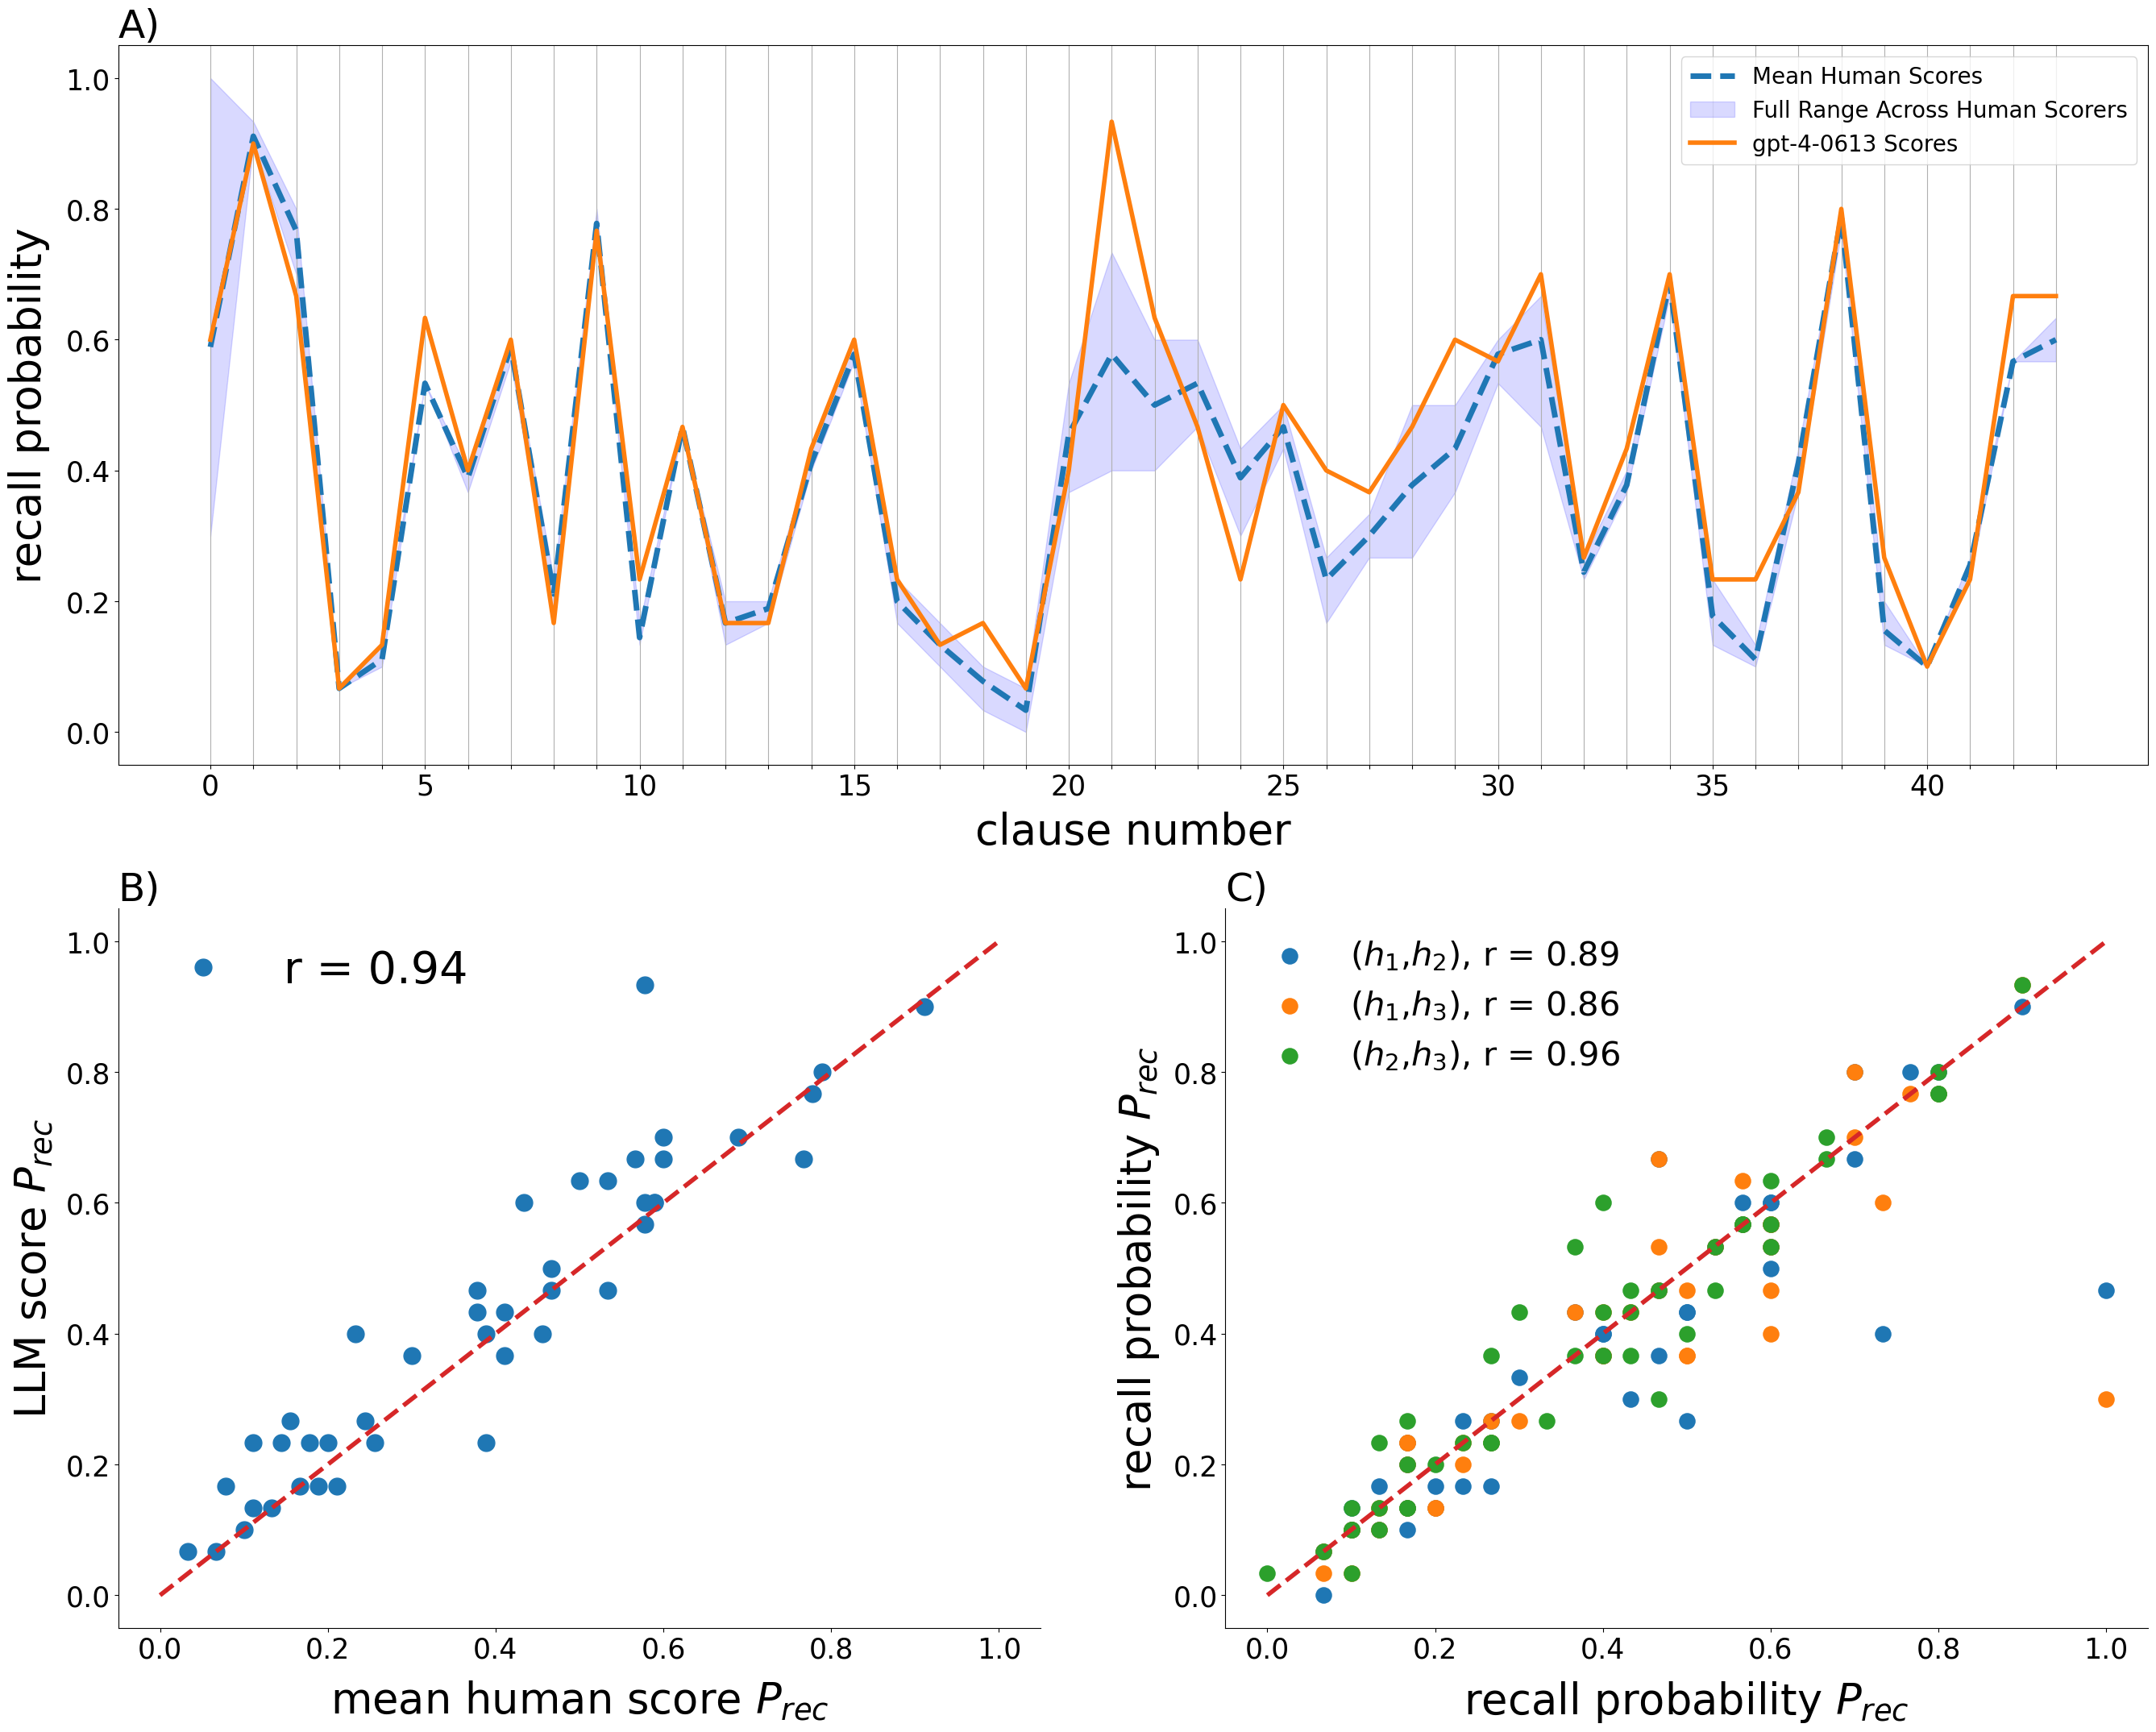

In [346]:
fig = plt.figure(figsize=(32.5, 25.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])

ax = plt.gca()
ax0.set_xticks(np.arange(seg_length))


temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)

    
ax0.tick_params(axis='both', which='major', labelsize=25)

ax0.plot(np.arange(1,seg_length+1)-1,human_hit_mean,'--',linewidth = 5,label = 'Mean Human Scores',color='tab:blue')
ax0.fill_between(np.arange(1,seg_length+1)-1,human_hit_min, human_hit_max, color='b', alpha=.15,label = 'Full Range Across Human Scorers')

ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_1.mean(axis=0),'-',markersize = 12,linewidth = 4,label='gpt-4-0613 Scores',color='tab:orange')


ax0.set_ylabel('recall probability',labelpad = 14,fontsize = 38)
ax0.set_xlabel('clause number', labelpad = 10,fontsize = 38)

ax0.xaxis.grid(True)
ax0.legend(fontsize= 20)



ax10 = fig.add_subplot(spec[1, 0])
rval = np.round(np.corrcoef(gpt_hit_1.mean(axis = 0),human_hit_mean.T)[0,1],2)
ax10.plot(human_hit_mean,gpt_hit_1.mean(axis = 0),'o',markersize = 15,label = 'r = '+str(rval))
ax10.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax10.tick_params(axis='both', which='major', labelsize=25)
ax10.set_xlabel('mean human score $P_{rec}$',labelpad = 14,fontsize = 38)
ax10.set_ylabel('LLM score $P_{rec}$', labelpad = 10,fontsize = 38)

ax10.legend(fontsize = 40,frameon=False)


r_human = np.corrcoef(human_data)

rval01 = np.round(r_human[0,1],2)
rval02 = np.round(r_human[0,2],2)
rval12 = np.round(r_human[1,2],2)
ax11 = fig.add_subplot(spec[1, 1])

ax11.scatter(human_data[0],human_data[1],s = 190,label = '($h_{1}$,$h_{2}$), r = '+str(rval01))
ax11.scatter(human_data[0],human_data[2],s = 190,label = '($h_{1}$,$h_{3}$), r = '+str(rval02))
ax11.scatter(human_data[1],human_data[2],s = 190,label = '($h_{2}$,$h_{3}$), r = '+str(rval12))
ax11.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax11.tick_params(axis='both', which='major', labelsize=25)
ax11.set_xlabel('recall probability $P_{rec}$',labelpad = 14,fontsize = 38)
ax11.set_ylabel('recall probability $P_{rec}$', labelpad = 10,fontsize = 38)


ax0.set_title('A)', loc = 'left',fontsize = 35)
ax10.set_title('B)', loc = 'left',fontsize = 35)
ax11.set_title('C)', loc = 'left',fontsize = 35)

ax11.legend(fontsize = 30,frameon=False)

ax_set = [ax11,ax10]
for _ax in ax_set:

    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)


plt.savefig('figs/figure-reliability.pdf',bbox_inches = 'tight')
plt.show()



## Inter-LLM reliability (Appendix B, Figure 5)

In [347]:
A = np.zeros((total_seg,4))

A[:,0] = human_hit_mean

A[:,1] = gpt_hit_davinci.mean(axis = 0)
A[:,2] = gpt_hit_turbo.mean(axis = 0)

A[:,3] = gpt_hit_1.mean(axis = 0)



correlation_matrix = np.corrcoef(A.T)



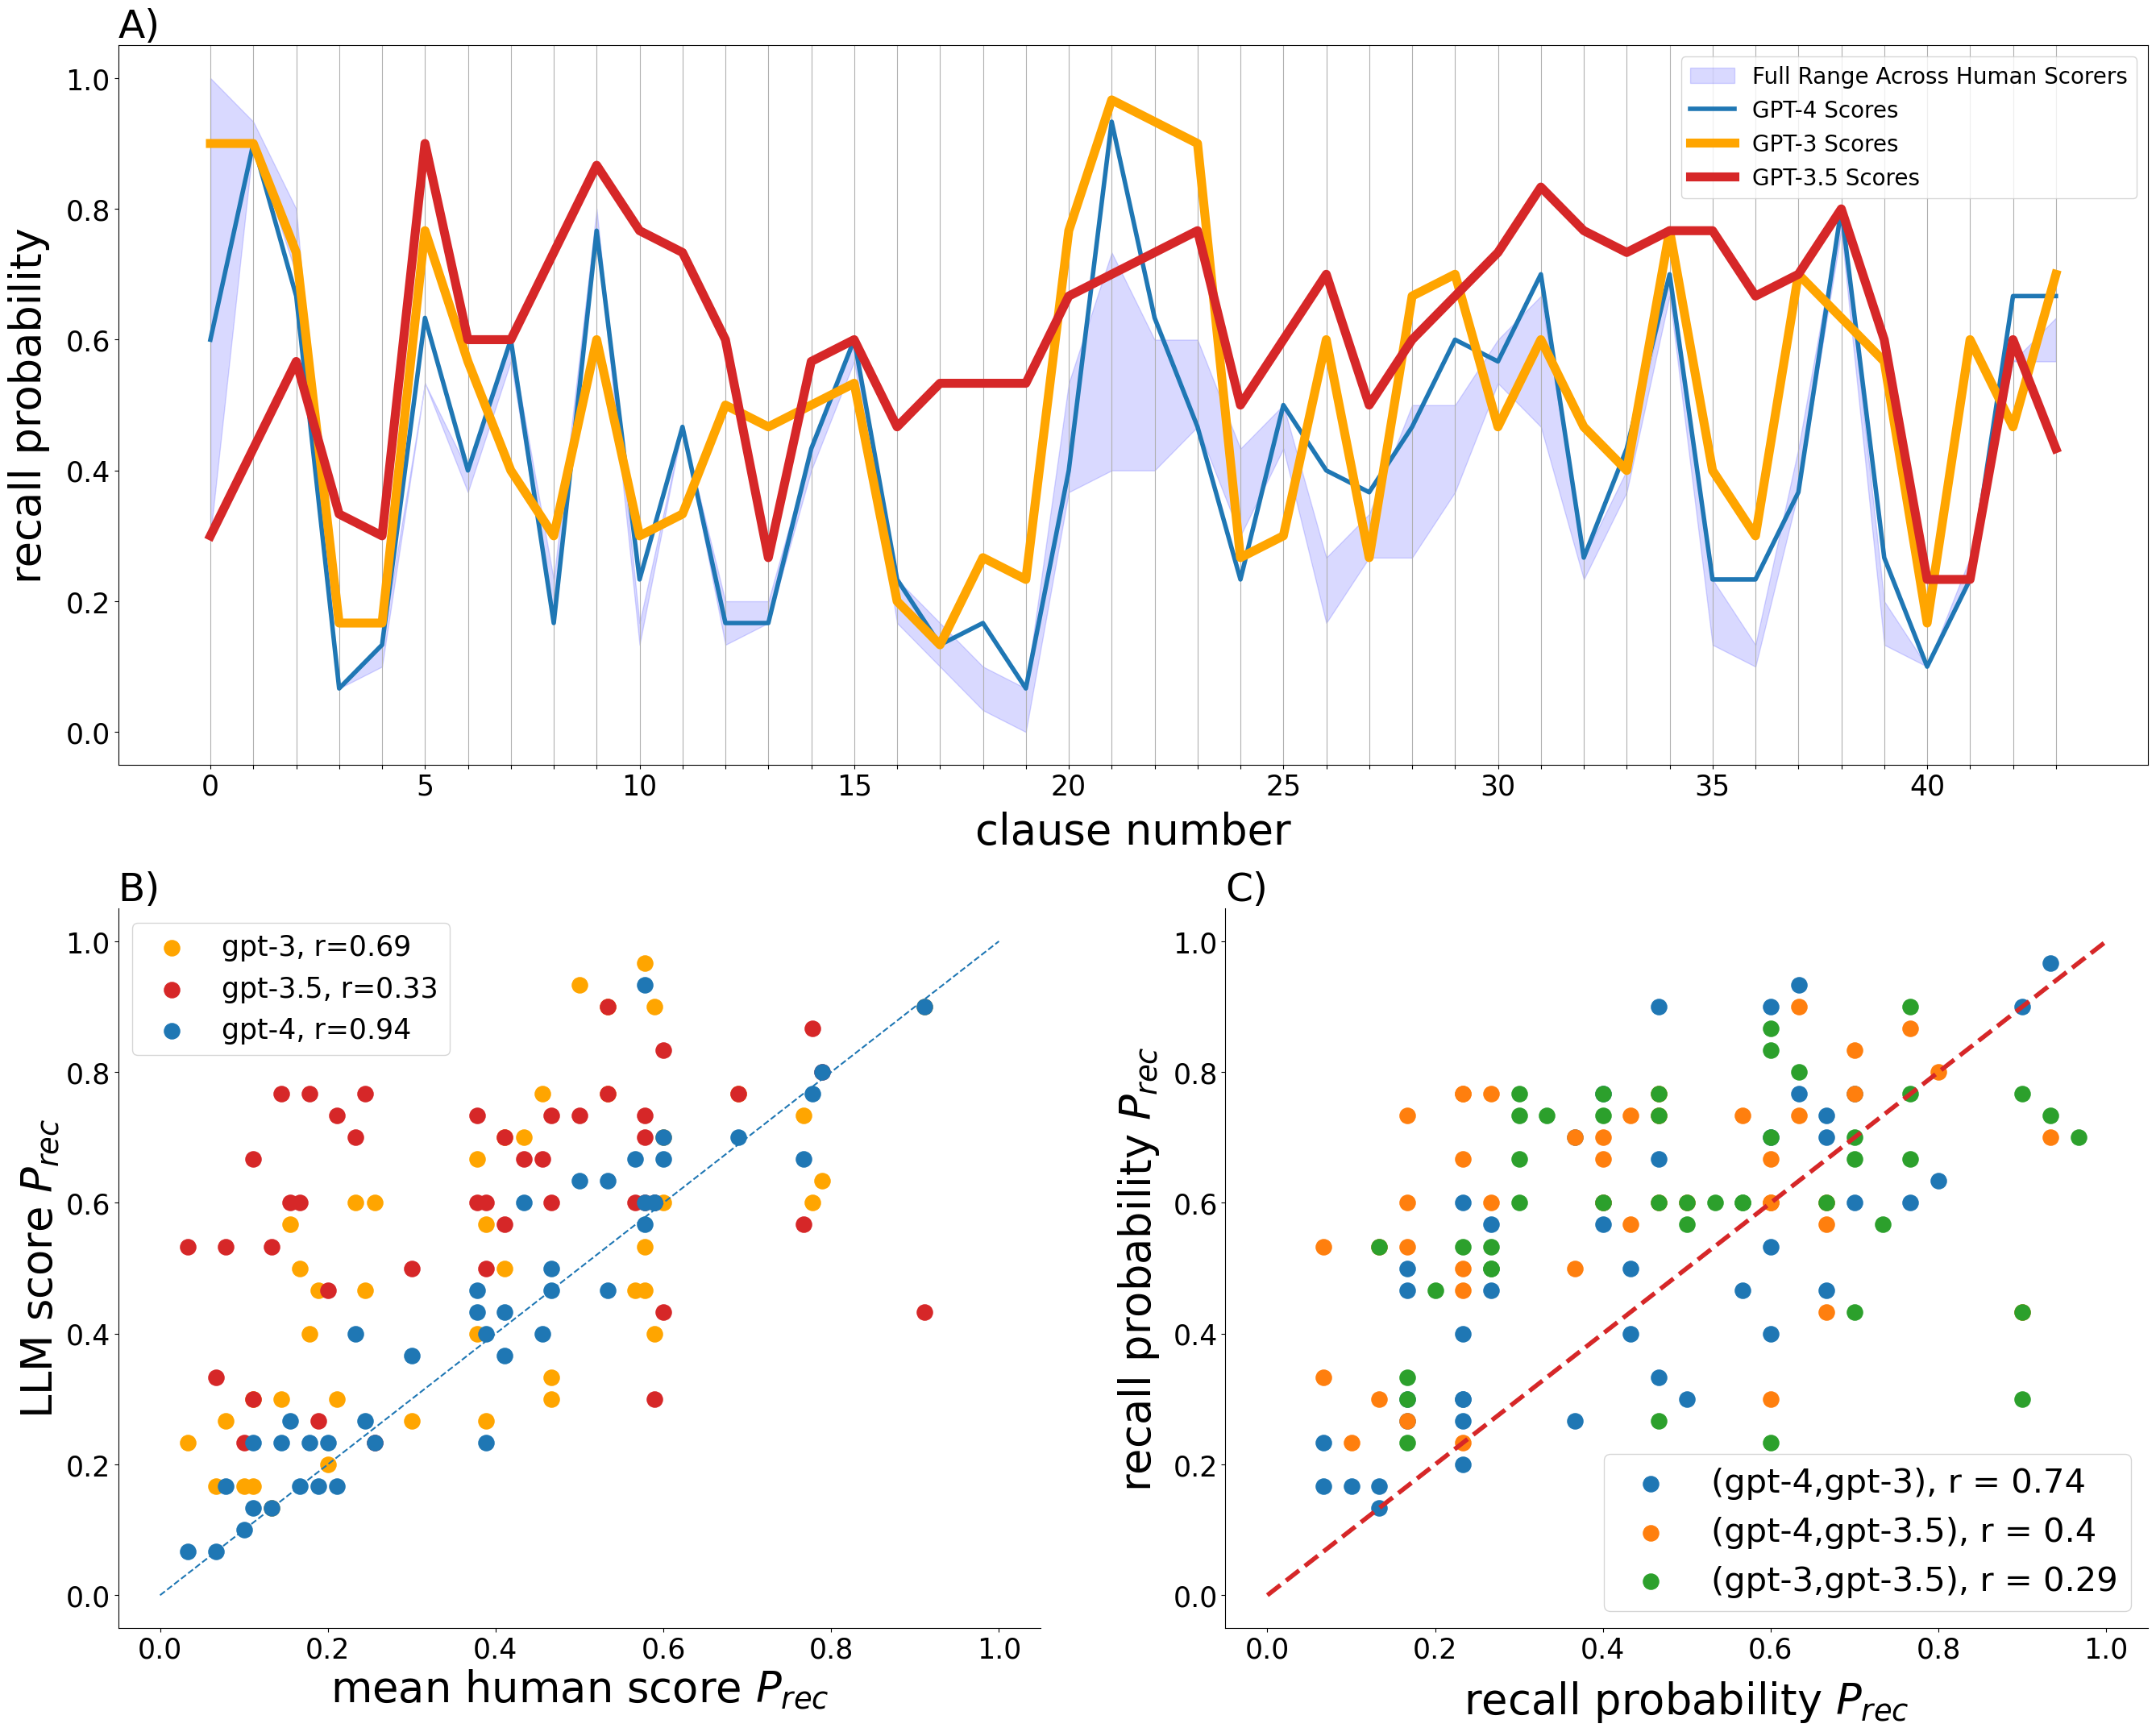

In [365]:
fig = plt.figure(figsize=(32.5, 25.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])

ax = plt.gca()
ax0.set_xticks(np.arange(seg_length))


temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)


#ax.set_xticks(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(np.arange(1,seg_length+1)) # range of values in edges

#ax0.set_xticks(fontsize=14)
#ax0.set_yticks(fontsize=14)

ax0.tick_params(axis='both', which='major', labelsize=25)

#ax0.plot(np.arange(1,seg_length+1)-1,human_hit_mean,'--',linewidth = 7,label = 'Mean Human Scores',color='tab:blue')
ax0.fill_between(np.arange(1,seg_length+1)-1,human_hit_min, human_hit_max, color='b', alpha=.15,label = 'Full Range Across Human Scorers')

ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_1.mean(axis=0),'-',markersize = 12,linewidth = 4,label='GPT-4 Scores',color='tab:blue')

ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_davinci.mean(axis=0),'-',markersize = 12,linewidth = 8,label='GPT-3 Scores',color='orange')
ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_turbo.mean(axis=0),'-',markersize = 12,linewidth = 8,label='GPT-3.5 Scores',color='tab:red')


ax0.set_ylabel('recall probability',labelpad = 14,fontsize = 38)
ax0.set_xlabel('clause number', labelpad = 10,fontsize = 38)

ax0.xaxis.grid(True)

ax0.legend(fontsize= 20)



ax10 = fig.add_subplot(spec[1, 0])
#annotate_axes(ax10, 'ax10')


labels = ['3','3.5','4']
colors = ['orange','tab:red','tab:blue']
for i in range(1,4):
    rval = np.round(correlation_matrix[0,i],2)
    ax10.scatter(A[:,0][:],A[:,i][:],s = 190,label='gpt-'+labels[i-1]+', r='+str(rval),color = colors[i-1])
#plt.scatter(A[:,0][:],A[:,2][:],label='gpt-4, r= 0.94')
#plt.scatter(A[:,0][:],A[:,3][:],label='gpt-3.5, r= 0.40')
ax10.plot([0,1],[0,1],'--')

#ax10.set_title('Performance of Different LLMs',fontsize = 20)
ax10.set_xlabel('mean human score $P_{rec}$',fontsize = 38)
ax10.set_ylabel('LLM score $P_{rec}$',fontsize = 38)

#rval = np.round(np.corrcoef(gpt_hit_1.mean(axis = 0),human_hit_mean.T)[0,1],2)
#ax10.plot(human_hit_mean,gpt_hit_1.mean(axis = 0),'o',markersize = 15,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_chat.mean(axis = 0),s = 70,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
#ax10.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax10.tick_params(axis='both', which='major', labelsize=25)
#ax10.set_xlabel('Mean Human Score $P_{rec}$',labelpad = 14,fontsize = 38)
#ax10.set_ylabel('LLM Score $P_{rec}$', labelpad = 10,fontsize = 38)

ax10.legend(fontsize = 25)


r_human = np.corrcoef(human_data)


rval31 = np.round(correlation_matrix[1,3],2)
rval32 = np.round(correlation_matrix[2,3],2)
rval12 = np.round(correlation_matrix[1,2],2)
#rval01 = np.round(r_human[0,1],2)
#rval02 = np.round(r_human[0,2],2)
#rval12 = np.round(r_human[1,2],2)
ax11 = fig.add_subplot(spec[1, 1])

#ax11.scatter(gpt_hit_1.mean(axis = 0),gpt_hit_3.mean(axis = 0),s = 190,label = 'r = '+str(rval))

ax11.scatter(A[:,3],A[:,1],s = 190,label = '(gpt-4,gpt-3), r = '+str(rval31))
ax11.scatter(A[:,3],A[:,2],s = 190,label = '(gpt-4,gpt-3.5), r = '+str(rval32))
ax11.scatter(A[:,1],A[:,2],s = 190,label = '(gpt-3,gpt-3.5), r = '+str(rval12))
#ax11.scatter(human_data[0],human_data[1],s = 190,label = '($h_{1}$,$h_{2}$), r = '+str(rval01))
#ax11.scatter(human_data[0],human_data[2],s = 190,label = '($h_{1}$,$h_{3}$), r = '+str(rval02))
#ax11.scatter(human_data[1],human_data[2],s = 190,label = '($h_{2}$,$h_{3}$), r = '+str(rval12))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
ax11.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax11.tick_params(axis='both', which='major', labelsize=25)
ax11.set_xlabel('recall probability $P_{rec}$',labelpad = 14,fontsize = 38)
ax11.set_ylabel('recall probability $P_{rec}$', labelpad = 10,fontsize = 38)


ax0.set_title('A)', loc = 'left',fontsize = 35)
ax10.set_title('B)', loc = 'left',fontsize = 35)
ax11.set_title('C)', loc = 'left',fontsize = 35)

ax11.legend(fontsize = 30)
#annotate_axes(ax11, 'ax11')

#ax0.set_title('Reliability of different LLMs for Scoring Narratives',fontsize = 38,pad = 15)
#ax10.set_title('Performance of different LLMs',fontsize = 38)
#ax11.set_title('Inter-LLM scores',fontsize = 38)

ax_set = [ax11,ax10]
for _ax in ax_set:
    #_ax.legend(fontsize = 14,frameon=False)
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)



plt.savefig('figs/inter-LLM-reliability.pdf',bbox_inches = 'tight')
plt.show()



# Scaling law in narrative recall (Figure 2)

# Recognition Analysis

Below are two functions which are used to compute the mean $\langle M\rangle$ and the variance via bootstrap. First, to set up notation, the recognition data for each participant is ${\bf x}^{\mu}(t) \in \{-1,0,1\}^{2L}$, where the $2L$ vector encodes the outcome of the recognition experiment for trial $t$, in the following way. 

For a given story with $L$ clauses, the pool of subjects is exposed to $L$ lures. We index the clauses $i = 1, ..., L$, and the lures $i = L+1, ..., 2L$. In a given trial, we denote the sequence of clauses/lures as $i_{t}$ for $t = 1, ...,S$. 

The outcome of a trial will take one of the following values:

- $o^{+}$: true positive, or equivalently 'hit'
-  $o^{-}$: true negative, or a 'miss'
- $l^{+}$: false positive, or a 'false alarm'
- $l^{-}$: false negative, or a 'correct rejection'

We can encode this in our vector encoding of the outcome in the following way. Let $o^{+} = l^{+}  =  1$ and $o^{-}= l^{-}  =  -1$. Then let $X^{\mu}(t)$ encode this value for each outcome. In other words, $X^{\mu}(t)$ only records whether the subjects says 'Yes' or 'No'. Then


$x_{i}^{\mu}(t) = \delta_{i i_{t}} X^{\mu}(t)$


"recog_hit_matrix" computes precisely this third-order tensor $x_{i}^{\mu}(t)$. 



From this representation, we can extract some useful quantities. 


 - pTPR (Population True Positive Rate): We obtain this from the formula (note the summation over $i$ is restricted to values $\le L$)
 \begin{equation}
 pTPR(L) = \frac{1}{2} \frac{\sum_{\mu,t} \sum_{i = 1}^{L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=1}^{L} | x_{i}^{\mu}(t)|}
 \end{equation}

The reason is that $\sum_{\mu, t} \sum_{i = 1}^{L} x_{i}^{\mu}(t) = H - M$, where $H$ is the total hits and $M$ is the total misses. Whereas $\sum_{\mu, t} \sum_{i = 1}^{L} |x_{i}^{\mu}(t)| = H + M$. This quantity is therefore equivalent to $H/(H+M)$. 

 - pFPR (Population False Positive Rate): We obtain this from the formula
 \begin{equation}
 pFPR(L) = \frac{1}{2} \frac{\sum_{\mu, t} \sum_{i = L+1}^{2L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=L+1}^{2L} | x_{i}^{\mu}(t)|}
 \end{equation}

Notice that the only difference here is the summation of $i$ goes from $L+1$ to $2L$. This quantity therefore is equavalent to $FA/(FA + CR)$

- Recognition Probability 
\begin{align}
 m_{i} = \frac{1}{2} \frac{\sum_{\mu, t}  \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t} | x_{i}^{\mu}(t)|}
\end{align}

This is computed by keeping the clause fixed, and computing the $H_{i}/(H_{i} + M_{i})$ for a given clause $i$. 


The estimate for the total number of clauses encoded is given by the formula

\begin{align}
\langle M \rangle = L \frac{\Big(pTPR - pFPR \Big)}{1 - pFPR}
\end{align}


To get this, we start the probability of a hit $P_{h}$, and relate it to the probability of a false alarm $P_{f}$:


\begin{align}
P_{h} = P(yes|m \in M)P(m \in M) + P(yes| m \notin M) P(m \notin M)\\
P_{h} = M/L + P_{f} (1 - M/L) = P_{f} + (1- P_{f}) M/L
\end{align}
So that

\begin{align}
 M = \frac{L}{1-P_{f}} \left( P_{h} - P_{f}\right)
\end{align}




In [349]:
# this function lists all the files in the dataset folder

def files_in_folder(folder, ext):
    files_datasets = []
    for fname in os.listdir(os.path.join('data/', folder)):
        if not fname.endswith(ext):
            continue
        yield fname

#This function constructs the basic third-order tensor which encapsulates the recognition data

def recog_hit_matrix(dataset):
    segmentation = dataset['segmentation']
    seg_list = segmentation.split('\n')
    lure_list = list(dataset['lures'].values)
    clause_pool = seg_list + lure_list
    L = len(seg_list)
    recog_data = dataset['recognition']
    pop = len(recog_data)
    T = len(recog_data[0])
    id_len = len(clause_pool)
    recog_arr = np.zeros((pop,id_len,T))

    recog_data_num = []

    for p in range(pop):
        T = len(recog_data[p])
        r_p = []
        for t in range(T):
            rdvec = recog_data[p][t]
            outcome = rdvec['value'] 
            idx = rdvec['id']
            if idx < id_len:
                if outcome == 'hit' or outcome == 'fa':
                    bin_outcome = 1.;
                    r_p +=[[idx,1]];
                else:
                    bin_outcome = -1.;
                    r_p +=[[idx,0]]

                recog_arr[p,idx,t] = bin_outcome
    
    return recog_arr


#############################################
# These are very similar functions, just with different arguments


#This funcion depends on T, and does not 
def recog_prob(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum(axis = 2).sum(axis = 0)    # Sum over Trial and Population
    tot = abs(recog_arr[:,:L,:T]).sum(axis = 2).sum(axis = 0)
    
    dh_lure = recog_arr[:,L:,:T].sum(axis = 2).sum(axis = 0)
    tot_lure = abs(recog_arr[:,L:,:T]).sum(axis = 2).sum(axis = 0)
    
    return  .5*(dh + tot)/tot, .5*(dh_lure + tot_lure)/tot_lure

def recog_prob_dist(dataset):     #takes only dataset as input
    r_mat = recog_hit_matrix(dataset)
    T = r_mat.shape[2]
    hr, far = recog_prob(r_mat,T)
    
    #L = int(r_mat.shape[1]/2)
    #rdiff = r_mat[:,:L,:].sum(axis=2).sum(axis=0)     #sum over ALL trials and Population
    #rsum = abs(r_mat[:,:L,:]).sum(axis=2).sum(axis=0)
    #r_prob = .5*(rdiff+rsum)/rsum
    return hr,far






#############################################

#This leaves T, total number of trials, an adjustable argument to compute the population averaged M

def mean_recog(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum()
    tot = abs(recog_arr[:,:L,:T]).sum()
    tpr = .5*(dh + tot)/tot
    
    dh_lure = recog_arr[:,L:,:T].sum()
    tot_lure = abs(recog_arr[:,L:,:T]).sum()
    far = .5*(dh_lure + tot_lure)/tot_lure
    
    
    
    return  L*(tpr + far)/(1 - far) #L*(1 - 2*(1 - tpr))
    

    
def tpr_time(recog_arr):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:].sum(axis=0).sum(axis = 0)
    tot = abs(recog_arr[:,:L,:]).sum(axis=0).sum(axis = 0)
    tpr = .5*(dh + tot)/tot
    
    
    return  L, tpr




        #This computes the mean and standard deviation of the population vector
def R_stats(dataset):
    recall_data = dataset['recall scores']
    segmentation = dataset['segmentation'] 
    recall_hits = get_hit_matrix(recall_data,segmentation)
    R_pop = recall_hits.sum(axis = 1)
    #N_pop = recall_hits.shape[0]
    #R_mean = recall_hits.sum()/N_pop
    #R_var = np.matmul(recall_hits.T,recall_hits).sum()/N_pop - R_mean**2
    return R_pop.mean(), R_pop.std()


def M_probs(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)   #use to be random.sample
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return TPR, FAR

#Compute M from the population

def M_sample(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return L*(TPR - FAR)/(1 - FAR)



# collect many bootstrap samples
def M_stats(dataset,sample_frac,samples):
    m_samp = []
    for i in range(samples):
        m_samp += [M_sample(dataset,sample_frac)]
    
    return np.array(m_samp)


In [350]:
# Set bootstrap parameters for estimating errors of M
sample_frac = 1.;   #sets fraction of dataset to sample from, used 0.2 before
samples = 2000;  #how many samples to collect for bootstrap, used 500 before

Rm = []
R_err = []
Mm = []
M_err = []
Lx = []

story_name = []

tpr_x = []
far_x = []

for f in files_in_folder('compiled_data', '.pkl'):
    if f not in ['ghosts.pkl']:        #f!='ghosts' and f!='hester_v2-church-scrambled':
        print('     ', f)
        fn = 'data/compiled_data/' + f
        dataset = pd.read_pickle(fn)
        Lx +=[len(dataset['segmentation'].split('\n'))]
        
        r_mean,r_std = R_stats(dataset)
        
        mt_pop = M_stats(dataset,sample_frac,samples)
        
        tpr, far = M_probs(dataset,1.)
        
        tpr_x +=[tpr]
        far_x +=[far]
        
        n = len(dataset['recall scores'])
        Rm +=[r_mean]
        R_err +=[r_std/np.sqrt(n)]

        Mm +=[mt_pop.mean()]
        M_err+=[np.std(mt_pop,ddof=1)]

        story_name +=[f]


      schissel_v1-pool.pkl
      triplett_v1-rookie.pkl
      hester_v2-church.pkl
      triplett_v2-catlady.pkl
      panic.pkl
      boyscout-scrambled.pkl
      schissel_v2-lake.pkl
      triplett_v1-rookie-scrambled.pkl
      hester_v2-church-scrambled.pkl
      boyscout.pkl
      stein-scrambled.pkl
      hester_v1-park.pkl
      stein.pkl


In [351]:
#these stories are excluded for fitting purposes

exclude_set = ['panic','biker','hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']


#these the scrambled stories
scram_set = ['hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']

arg_include = [] 
arg_exclude = []
for i in range(len(story_name)):
    s = story_name[i][:-4]
    if s not in exclude_set:
        arg_include +=[i]
    
    elif s in scram_set:
        arg_exclude +=[i]

arg_include = np.array(arg_include)

arg_exclude = np.array(arg_exclude)

In [352]:
rt = np.array(Rm)[arg_include]
mt = np.array(Mm)[arg_include]
lt = np.array(Lx)[arg_include]
rt_error = np.array(R_err)[arg_include]
mt_error = np.array(M_err)[arg_include]


TPR= np.array(tpr_x)[arg_include]
FAR = np.array(far_x)[arg_include]
rt_sc = np.array(Rm)[arg_exclude]
mt_sc = np.array(Mm)[arg_exclude]
lt_sc = np.array(Lx)[arg_exclude]
rt_error_sc = np.array(R_err)[arg_exclude]
mt_error_sc = np.array(M_err)[arg_exclude]

TPR_sc = np.array(tpr_x)[arg_exclude]
FAR_sc = np.array(far_x)[arg_exclude]

In [353]:
#fitting the slope

rm_regress =linregress(mt,rt)


rl_regress = linregress(lt[:],rt[:])

ml_regress = linregress(lt[:],mt[:])



rm_regress_log =linregress(np.log(mt),rt)


r_r, pval_r = stats.pearsonr(lt, rt)
r_m,pval_m = stats.pearsonr(lt, mt)


    
r_mr,pval_mr = stats.pearsonr(mt, rt)

r_m,pval_m = stats.pearsonr(lt, mt)
r_mr,pval_mr = stats.pearsonr(mt, rt)


x = np.array(lt)
y = np.array(rt)
x = x[:,np.newaxis]
aR, _, _, _ = np.linalg.lstsq(x, y,rcond = None)

x2 = np.array(lt)
y2 = np.array(mt)
x2 = x2[:,np.newaxis]
aM, _, _, _ = np.linalg.lstsq(x2, y2,rcond = None)


x3 = np.array(mt)
y3 = np.array(rt)
x3 = x3[:,np.newaxis]
aRM,_, _, _ = np.linalg.lstsq(x3, y3,rcond = None)

In [354]:
rm_slope = rm_regress.slope
rm_intercept = rm_regress.intercept
rm_rvalue = rm_regress.rvalue

rm_log_slope = rm_regress_log.slope
rm_log_intercept = rm_regress_log.intercept
rm_log_rvalue = rm_regress_log.rvalue

rl_slope = np.round(rl_regress.slope,2)
rl_intercept = np.round(rl_regress.intercept,2)

ml_slope = np.round(ml_regress.slope,2)
ml_intercept = np.round(ml_regress.intercept,2)

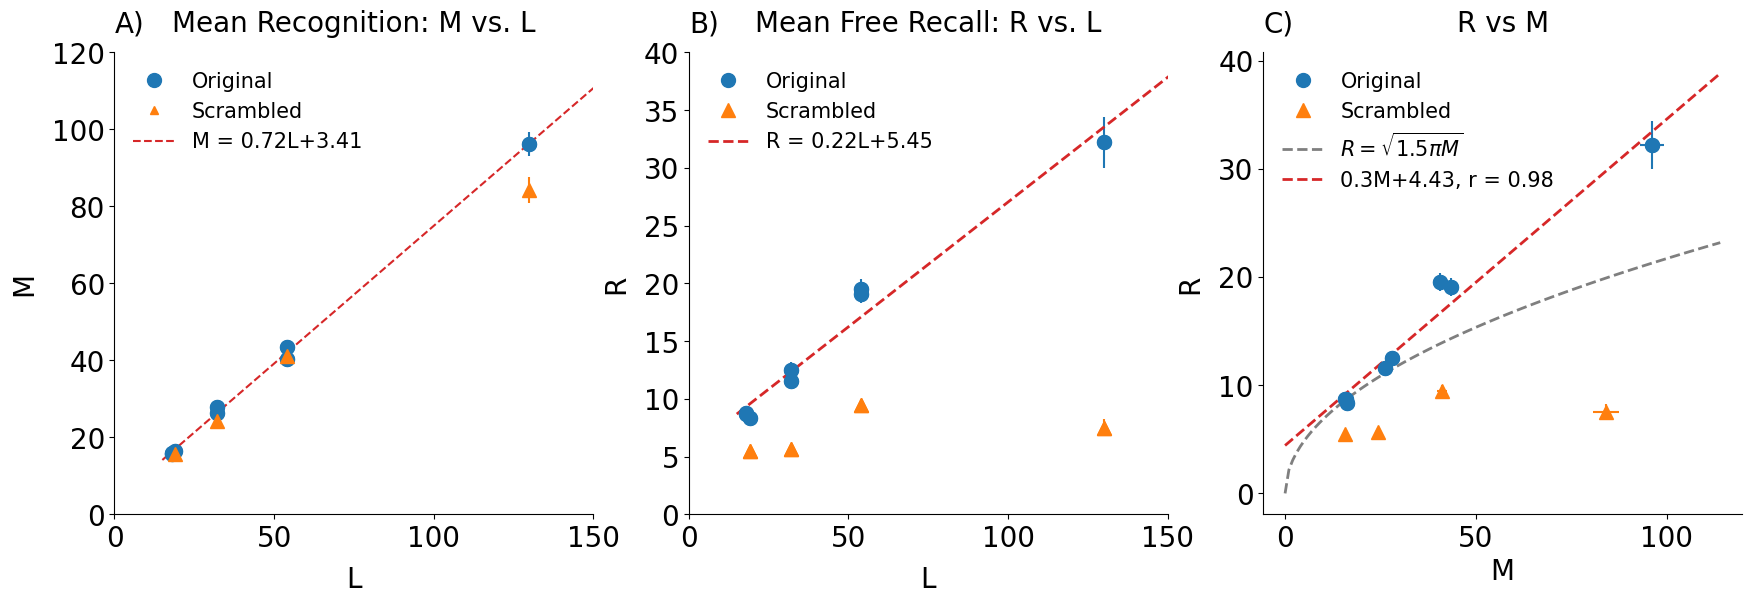

In [355]:

M_min = int(min(mt))
L_max= 2*int(max(lt))

ll = np.array([x for x in range(M_min,L_max)])




M_min = 0*int(min(mt))
M_max= int(1.2*max(mt))

m = np.array([x for x in range(M_min,M_max)])



fig, ax = plt.subplots(1,3,figsize=(21,6))#

#fig, ax = plt.subplot_mosaic([['a)', 'b)','c)']],
 #                             layout='constrained',figsize = (15,5))


ax[0].plot(lt, mt, 'o',markersize = 10,label='Original',color='tab:blue')
ax[0].errorbar(lt, mt, yerr=mt_error,fmt='o',markersize = 10,color = 'tab:blue')


ax[0].plot(lt_sc, mt_sc, '^',label='Scrambled',color='tab:orange')
ax[0].errorbar(lt_sc, mt_sc, yerr = mt_error_sc,fmt='^',markersize = 10,color = 'tab:orange')

#ax[0].plot(ll,(aM)*ll,'--',color = 'tab:red',label='M = '+str(np.round(aM[0],2))+'L, r = ' + str(np.round(r_m,3)))
ax[0].plot(ll,(ml_regress.slope.item())*ll+ml_regress.intercept.item(),'--',color = 'tab:red',label='M = '+str(ml_slope)+'L+'+str(ml_intercept))




ax[0].set_xlim([0, 150])
ax[0].set_ylim([0, 120])
#ax[0].legend( frameon=False )
ax[0].set_title('Mean Recognition: M vs. L',fontsize=20,pad = 20)
ax[0].set_title('A)',  loc='left', fontsize=20, pad = 15)
ax[0].set_ylabel('M',labelpad = 10,fontsize = 20)
ax[0].set_xlabel('L',labelpad = 10,fontsize = 20)




ax[1].plot(lt, rt, 'o',markersize = 10,label='Original',color='tab:blue')
ax[1].errorbar(lt, rt, yerr=rt_error,markersize= 10,fmt='o',color='tab:blue')

ax[1].plot(lt_sc, rt_sc, '^',markersize = 10,label='Scrambled',color='tab:orange')
ax[1].errorbar(lt_sc, rt_sc, yerr = rt_error_sc,fmt='^',markersize = 10,color = 'tab:orange')
ax[1].plot(ll,(rl_regress.slope.item())*ll+rl_regress.intercept.item(),'--',color = 'tab:red',
           label='R = '+str(rl_slope)+'L+'+str(rl_intercept), linewidth = 2 )

#, r = ' + str(np.round(rl_regress.rvalue,3))

ax[1].set_xlim([0, 150])
ax[1].set_ylim([0, 40])
#ax[1].legend(frameon=False)
ax[1].set_title('Mean Free Recall: R vs. L',fontsize=20,pad = 20)
ax[1].set_title('B)',  loc='left', fontsize=20,pad = 15)
ax[1].set_ylabel('R',labelpad = 10,fontsize=20)
ax[1].set_xlabel('L',labelpad = 10,fontsize=20)





ax[2].plot(mt, rt, 'o',markersize = 10, color ='tab:blue', label = 'Original')  #,label='R vs. M'
ax[2].errorbar(mt,rt,xerr = mt_error,yerr = rt_error,fmt = 'o',markersize = 10,color= 'tab:blue') #fmt='o',markersize = 4,alpha = 1.,

ax[2].plot(mt_sc, rt_sc, '^',markersize = 10, color = 'tab:orange',label = 'Scrambled')  #,label='R vs. M'

#ax[2].scatter(mt_sc, rt_sc, s=30,alpha=1, edgecolors="k",color = 'orange',label = 'Scrambled')  #,label='R vs. M'
ax[2].errorbar(mt_sc, rt_sc, xerr = mt_error_sc,yerr = rt_error_sc,fmt = '^',color = 'tab:orange')  #,label='R vs. M'


ax[2].plot(m,np.sqrt(3*np.pi/2)*np.sqrt(m),'--',color = 'tab:gray',label='$R = \sqrt{1.5 \pi M}$', linewidth = 2 )
#ax[2].plot(m,0.4096085405487828*m + 1.7540804817166027,'--',label = 'R = M',color = 'tab:red')
ax[2].plot(m,rm_slope*m +rm_intercept,'--',color = 'tab:red',
           label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)) + ', r = '+str(np.round(rm_rvalue,2)) ,
               linewidth = 2    )

#ax[2].plot(m,0.29*m +4.838,'-',color = 'tab:red',label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)))



#ax[2].set_xlim([0, 120])
#ax[2].set_ylim([0, 40])

ax[2].set_title('R vs M',fontsize = 20,pad = 15)
ax[2].set_title('C)',  loc='left', fontsize=20,pad = 15)
ax[2].set_ylabel('R',fontsize = 20,labelpad = 10)
ax[2].set_xlabel('M',fontsize = 20)

for k in range(3):
    ax[k].legend(fontsize = 15,frameon=False)
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)

    ax[k].tick_params(axis='both', which='major', labelsize=20)

plt.savefig('figs/scaling-plots.pdf', bbox_inches='tight')

plt.show()


# Temporal order of recall (Figure 3)

In [356]:
#This extracts the data to be plotted below

order_list = []
max_len = []
story_name = []
for f in files_in_folder('compiled_data', '.pkl'):
    fn = 'data/compiled_data/' + f
    dataset = pd.read_pickle(fn)
    
    _r = dataset['recall_scores_ordered'].values
    order_list += [_r]
    max_len +=[len(dataset['segmentation'].split('\n'))]
    story_name +=[f]
#This is the random list data

fn = 'data/words/rec_pos_words_128.pkl'
word_data_2 = pd.read_pickle(fn)
word_recall = word_data_2['rec_pos']

order_list +=[np.array(word_recall,dtype = object)]
story_name +=['random list']
max_len +=[128]

In [357]:

story_file = 'hester_v2-church-scrambled.pkl'
fn = 'data/compiled_data/'+story_file
dataset_scram = pd.read_pickle(fn)
scramble_map = np.array(dataset_scram['scramble_map'])
clause_map = scramble_map+1
#hester-ordered_list
#hester-scrambled data is 

story_index = np.argwhere(np.array(story_name)==story_file).item()
seq_list = order_list[story_index]
serial_seq_list = []
for i in range(len(seq_list)):
    seq = seq_list[i]
    serial_seq = []
    for _s in seq:
        serial_seq +=[np.argwhere(clause_map ==_s).item() + 1]
    
    serial_seq_list +=[serial_seq]

serial_seq_list = np.array(serial_seq_list,dtype = object)

In [358]:
np.argwhere(np.array(story_name)=='hester_v2-church-scrambled.pkl').item()

8

In [359]:
story_name

['schissel_v1-pool.pkl',
 'triplett_v1-rookie.pkl',
 'hester_v2-church.pkl',
 'triplett_v2-catlady.pkl',
 'panic.pkl',
 'boyscout-scrambled.pkl',
 'schissel_v2-lake.pkl',
 'triplett_v1-rookie-scrambled.pkl',
 'hester_v2-church-scrambled.pkl',
 'boyscout.pkl',
 'stein-scrambled.pkl',
 'hester_v1-park.pkl',
 'stein.pkl',
 'random list']

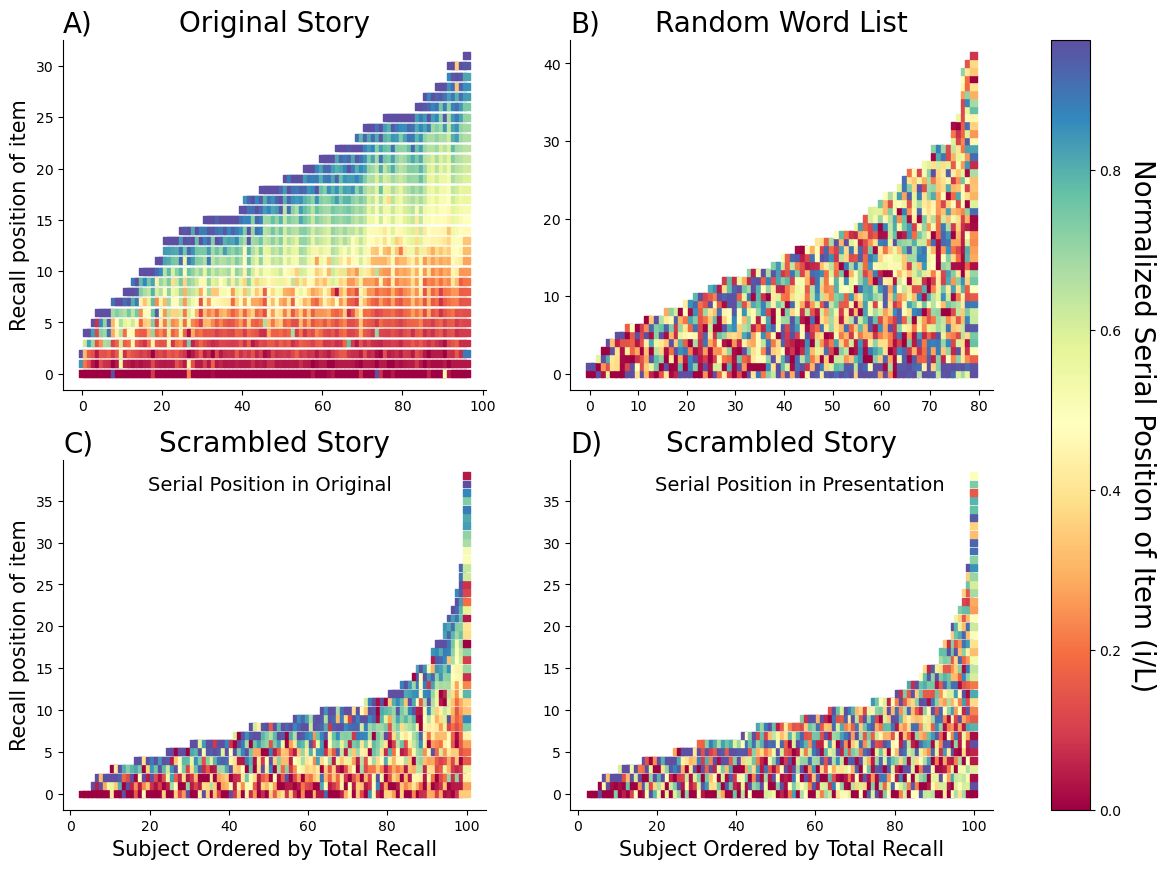

In [360]:
_id = np.argwhere(np.array(story_name)=='hester_v2-church.pkl').item()  #Coherent Story
_id2 = np.argwhere(np.array(story_name)=='random list').item() #random list

_id3 = np.argwhere(np.array(story_name)=='hester_v2-church-scrambled.pkl').item() # scrambled story

marker_size = 25
num_legend_elements = 5;
num_legend_elements2 = 6;

dimX = 15
dimY = 10

###########################
###########################

_r = order_list[_id]

r_tot = []
for rec in _r:
    r_tot +=[len(rec)]
idx_r_tot = np.argsort(r_tot)[:-3]

_r = _r[idx_r_tot]

###########################
###########################

_r2 = order_list[_id2]

r_tot2 = []
for rec in _r2:
    r_tot2 +=[len(rec)]

idx_r_tot2 = np.argsort(r_tot2)[:]

_r2 = _r2[idx_r_tot2]


###########################
###########################

_r3 = order_list[_id3]

r_tot3 = []
for rec in _r3:
    r_tot3 +=[len(rec)]

idx_r_tot3 = np.argsort(r_tot3)[:]

_r3 = _r3[idx_r_tot3]

###########################
###########################

_r4 = serial_seq_list

r_tot4 = []
for rec in _r4:
    r_tot4 +=[len(rec)]

idx_r_tot4 = np.argsort(r_tot4)[:]

_r4 = _r4[idx_r_tot4]







fig, ax = plt.subplots(2,2,figsize = (dimX,dimY))



for k in range(len(_r)):
    x = [k for i in range(len(_r[k]))]
    y=[i for i in range(len(_r[k]))]
    ys = (np.array(_r[k])-1)/(max_len[_id]-1)
    scatter1 = ax[0,0].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend1 = ax[0,0].legend(*scatter1.legend_elements(num = num_legend_elements),title="Serial Position of Clause (i/L)")
#ax[0,0].add_artist(legend1)

for k in range(len(_r2)):
    x = [k for i in range(len(_r2[k]))]
    y=[i for i in range(len(_r2[k]))]
    ys = (np.array(_r2[k])-1)/(max_len[_id2]-1)
    scatter2 = ax[0,1].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend2 = ax[0,1].legend(*scatter2.legend_elements(num = num_legend_elements),title="Serial Position of Word in Presentation (i/L)")
#ax[0,1].add_artist(legend2)


for k in range(len(_r3)):
    x = [k for i in range(len(_r3[k]))]
    y=[i for i in range(len(_r3[k]))]
    ys = (np.array(_r3[k])-1)/(max_len[_id3]-1)
    scatter3 = ax[1,0].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend3 = ax[1,0].legend(*scatter3.legend_elements(num = num_legend_elements),title="Serial Position in Original (i/L)")
#ax[1,0].add_artist(legend3)


for k in range(len(_r4)):
    x = [k for i in range(len(_r4[k]))]
    y=[i for i in range(len(_r4[k]))]
    ys = (np.array(_r4[k])-1)/(max_len[_id3]-1)
    scatter4 = ax[1,1].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(scatter1, cax = cax, ticks=[range(0, 100, 10)],orientation='vertical')    
    
#legend4 = ax[1,1].legend(*scatter4.legend_elements(num = num_legend_elements),title="Serial Position in Presention (i/L)")
#ax[1,1].add_artist(legend4)



ax[0,0].set_title('Original Story',fontsize = 20)
ax[0,0].set_title('A)',  loc='left',fontsize = 20)

ax[0,1].set_title('Random Word List',fontsize = 20)
ax[0,1].set_title('B)',  loc='left',fontsize = 20)

ax[1,0].set_title('Scrambled Story',fontsize = 20)
ax[1,0].set_title('C)',  loc='left',fontsize = 20)


ax[1,1].set_title('Scrambled Story',fontsize = 20)
ax[1,1].set_title('D)',  loc='left',fontsize = 20)


ax[1,1].set_xlabel('Subject Ordered by Total Recall',fontsize =15)
ax[1,0].set_xlabel('Subject Ordered by Total Recall',fontsize = 15)
ax[1,0].set_ylabel('Recall position of item',fontsize = 15)

ax[0,0].set_ylabel('Recall position of item',fontsize = 15)
#plt.ylabel('Recall Sequence')






# place a text box in upper left in axes coords
ax[1,0].text(19.5, 38.05, 'Serial Position in Original', fontsize=14,
        verticalalignment='top')

ax[1,1].text(19.5, 38.05, 'Serial Position in Presentation', fontsize=14,
        verticalalignment='top')


for k in range(2):
    for j in range(2):
        #ax[k,j].legend(fontsize = 14,frameon=False)
        ax[k,j].spines['top'].set_visible(False)
        ax[k,j].spines['right'].set_visible(False)

cbar = fig.colorbar(scatter4, ax=ax,orientation = 'vertical')

cbar.set_label('Normalized Serial Position of Item (i/L)', rotation=270,labelpad = 25,fontsize = 20)


#plt.xlabel('subject ordered by total recall')
#plt.ylabel('Recall position')
plt.savefig('figs/recall_sequence_narrative_vs_list.pdf',bbox_inches='tight')
plt.show()

# Prec vs Phit (Figure 4)

schissel_v1-pool.pkl 18
triplett_v1-rookie.pkl 32
hester_v2-church.pkl 54
triplett_v2-catlady.pkl 32
panic.pkl 56
schissel_v2-lake.pkl 18
boyscout.pkl 19
hester_v1-park.pkl 54
stein.pkl 130


<Figure size 1000x300 with 0 Axes>

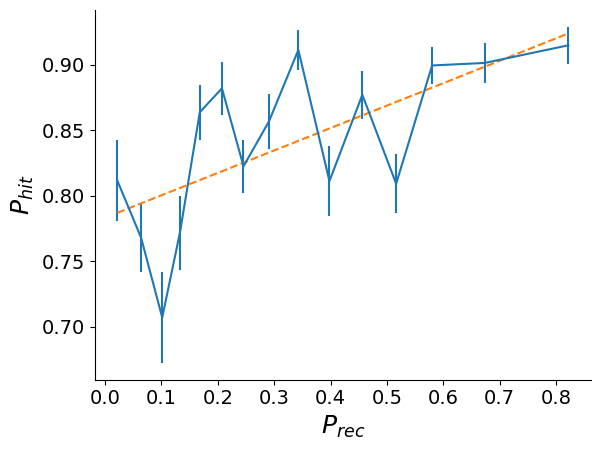

In [364]:
th= 0.15
n_th= 5
attracting_force= []
hit_stats= np.empty((0, 2), dtype= int)
p_recs= np.empty((0,))
for fname in os.listdir('data/compiled_data'):
    if "scrambled" in fname:
        continue
    print(fname, end=" ")
    data= pd.read_pickle(os.path.join('data/compiled_data',fname) )
    ordered_recall= data['recall_scores_ordered']
    segm= data["segmentation"].split("\n")


    n_clauses= len(segm)
    
    print(n_clauses)
    hit_stat= np.zeros( (n_clauses, 2), dtype= int)
    for recs in data['recognition']:
        for r in recs:
            if r['value'] in ['hit', 'miss']:
                hit_stat[r['id'], (r['value']=='hit')+0] += 1
    hit_stats= np.vstack( (hit_stats, hit_stat) )

    p_rec= np.zeros( (n_clauses+1), dtype= np.int64 )
    for s in ordered_recall:
        for s1 in s :
            p_rec[ s1 ] += 1
    
    p_rec= p_rec/len(ordered_recall)
    #print(  p_rec.shape, hit_stat.shape )
    p_recs= np.hstack( (p_recs, p_rec[1:]) )
    ii= np.argsort(p_rec)[::-1]
    #for k in sorted(ii[:len(ii)//4]):
    #for k in sorted(np.where(p_rec>0.5)[0]):
    #    print( f"Prec={p_rec[k]:.3f},  {segm[k-1]}" )

ii = hit_stats.sum(axis=1)>0
p_recs_good= p_recs[ii]
hit_stats_good= hit_stats[ii,:]

n_bins= 15
bin_boundaries= np.percentile( p_recs_good, np.linspace(0,100,n_bins+1) )
bin_boundaries[-1]= 1.0
bin_idx= np.digitize(p_recs_good, bin_boundaries)

bin_stats= np.zeros( (n_bins, 4) )
for k in range(n_bins):
    ii = (bin_idx==k+1)
    bin_stats[k,0]= (bin_boundaries[k]+bin_boundaries[k+1])/2
    bin_stats[k,1]= np.sum( hit_stats_good[ii, 0] )
    bin_stats[k,2]= np.sum( hit_stats_good[ii, 1] )
    bin_stats[k,3]= np.mean( p_recs_good[ii] )
p_hit_bin= bin_stats[:,2]/(bin_stats[:,1]+bin_stats[:,2])
p_hit_err= np.sqrt( p_hit_bin*(1-p_hit_bin)/(bin_stats[:,1]+bin_stats[:,2]) )
m,b = np.polyfit( bin_stats[:,3], p_hit_bin, 1)
plt.figure( figsize=(10,3) )
fig, ax = plt.subplots()
plt.errorbar(bin_stats[:,3], p_hit_bin, yerr= p_hit_err, label= "data")
plt.plot(bin_stats[:,3], m*bin_stats[:,3]+b, '--', label= f"y={m:.3f}x+{b:.3f}")
plt.xlabel("$P_{rec}$", fontsize=18)
plt.ylabel("$P_{hit}$", fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0,1)
plt.savefig('figs/p_hit_vs_p_rec.pdf')
    

# Output Interference (Appendix C, Figure 5)


To measure output interference, we use the $d'$ measure. This is defined as

\begin{equation}
d' = z(TPR) - z(FPR)
\end{equation}


where $z(p)$ is solved by the implicit equation

\begin{align}
p &= \int_{-\infty}^{z(p)} Dx = \frac{1}{2}\left( {\rm erf}(z(p)/\sqrt{2}) + 1\right),\\
z(p) &= \sqrt{2} {\rm erf}^{-1}\left( 2 p - 1\right)
\end{align}



The interest is in computing this quantity for each trial. This means, we need to use


- Trial resolved population TPR:
 \begin{equation}\label{eq:tpTPR}
 pTPR(t) = \frac{1}{2} \frac{\sum_{\mu} \sum_{i = 1}^{L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu}\sum_{i=1}^{L} | x_{i}^{\mu}(t)|}
 \end{equation}


And similarly for the trial resolved population FPR.

In [299]:
def z(p):
    return np.sqrt(2)*erfinv(2*p - 1)


#this produces an array of length $T$,
def recog_prob_pop(recog_arr):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:].sum(axis = 1).sum(axis = 0)
    tot = abs(recog_arr[:,:L,:]).sum(axis = 1).sum(axis = 0)
    
    dh_lure = recog_arr[:,L:,:].sum(axis = 1).sum(axis = 0)
    tot_lure = abs(recog_arr[:,L:,:]).sum(axis = 1).sum(axis = 0)
    
    return  .5*(dh + tot)/tot, .5*(dh_lure + tot_lure)/tot_lure


def get_z_score(dataset):
    recog_arr = recog_hit_matrix(dataset)
    hr,far = recog_prob_pop(recog_arr)
    z_hr = z(hr)
    z_far = z(far)
    return z_hr, z_far   #hr,far, 

In [309]:
file_names = files_in_folder('compiled_data','.pkl')

exclude_set = ['boyscout.pkl','panic.pkl']
scram_set = ['boyscout-scrambled.pkl','triplett_v1-rookie-scrambled.pkl','hester_v2-church-scrambled.pkl','stein-scrambled.pkl']
include_set = []
for f in file_names:
    if f not in exclude_set:
        include_set +=[f]

In [310]:
hr_list = []
far_list = []

zhr_list = []
zfar_list = []

dp_list = []
f_name = []

f_len = []

for f in include_set:

    fn = 'data/compiled_data/' + f
    dataset = pd.read_pickle(fn)
    #_hr, _far, _zh, _zf = get_z_score(dataset)
    
    _zh, _zf = get_z_score(dataset)
    
    #zhr_list +=[_zh]
    #zfar_list +=[_zf]
    
    #hr_list +=[_hr]
    #far_list +=[_far]
    dp_list +=[_zh - _zf]
    f_name += [f]
    
    f_len +=[len(dataset['segmentation'].split('\n'))]
    
dp_arr = np.array(dp_list)
#hr_arr = np.array(hr_list)
#far_arr = np.array(far_list)

#zhr_arr = np.array(zhr_list)
#zfar_arr = np.array(zfar_list)

In [311]:
#dp_list_sort = dp_arr[np.argsort(f_len)]
f_sorted = np.argsort(f_len)


#Compute mean d' score for coherent and scrambled stories

arg_scram = []
arg_coherent = []
for i in range(len(f_name)):
    if f_name[i] in scram_set:
        arg_scram +=[i]
    else:
        arg_coherent +=[i]
        
    
dmean_scram = dp_arr[np.array(arg_scram)].mean(axis = 0)
dmean_coherent = dp_arr[np.array(arg_coherent)].mean(axis = 0)

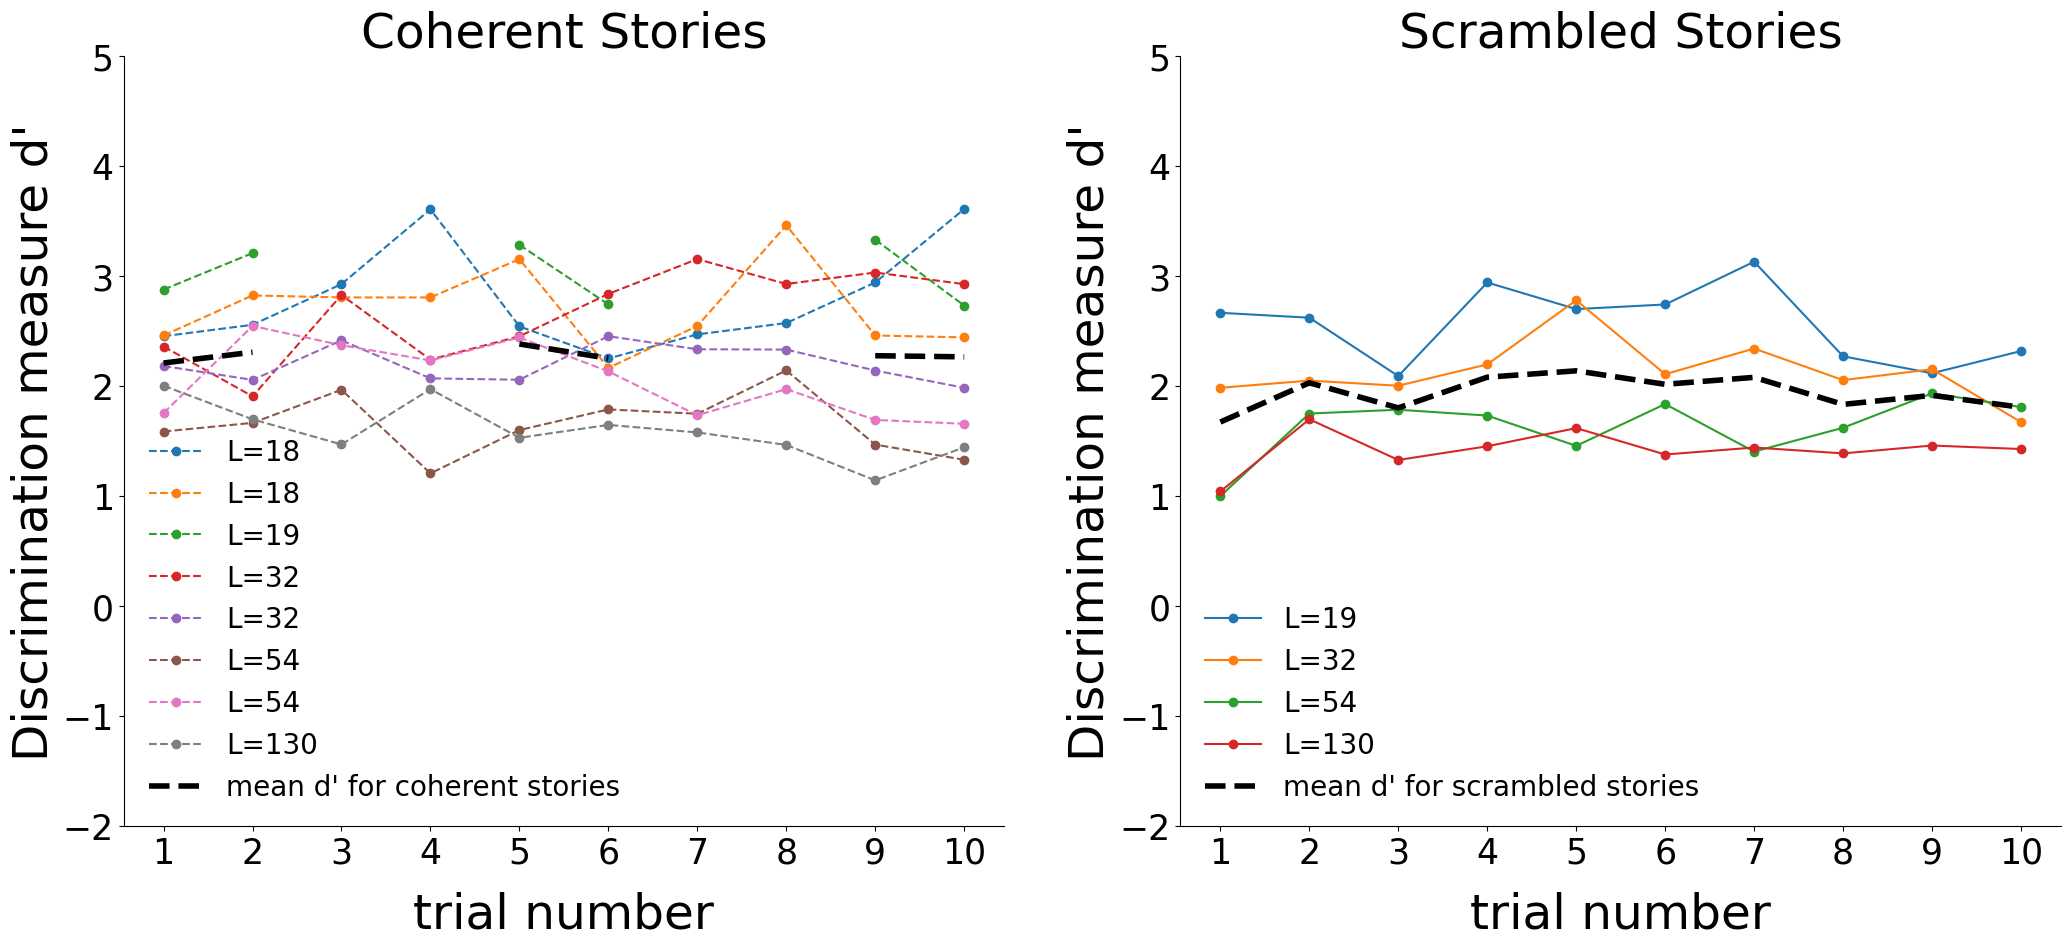

In [308]:

fig, ax = plt.subplots(1,2,figsize=(25,10))#

#ax = plt.gca()



for i in range(len(f_sorted)):
    i_s = f_sorted[i]
    if f_name[i_s] not in scram_set:
        ax[0].plot(np.arange(10)+1,dp_list[i_s],'--o',label = 'L='+str(f_len[i_s]))


for i in range(len(dp_list)):
    if f_name[i] in scram_set:
        ax[1].plot(np.arange(10)+1,dp_list[i],'-o',label = 'L='+str(f_len[i]))


ax[0].plot(np.arange(10)+1,dmean_coherent,'--',color = 'black',linewidth = 4,label = 'mean d\' for coherent stories')

ax[1].plot(np.arange(10)+1,dmean_scram,'--',color = 'black',linewidth = 4,label = 'mean d\' for scrambled stories')



for i in range(2):

    ax[i].set_ylim([-2, 5])

    ax[i].set_ylabel('Discrimination measure d\'',fontsize = 35)

    ax[i].set_xlabel('trial number',fontsize = 35,labelpad = 15)
    ax[i].legend(loc = 'lower left',fontsize = 18)#bbox_to_anchor=(.5, 1.))#, bbox_transform=ax.transAxes)
    ax[i].tick_params(axis='both', which='major', labelsize=20)

ax[0].set_xticks(np.arange(10)+1)


ax[1].set_xticks(np.arange(10)+1)

    
ax[0].set_title('Coherent Stories',fontsize = 35)
ax[1].set_title('Scrambled Stories',fontsize = 35)  # Discrimination measure d\' = z($t^{+}$) - z($f^{+}$)

for k in range(2):
    ax[k].legend(fontsize = 20,frameon=False)
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)

    ax[k].tick_params(axis='both', which='major', labelsize=25)



plt.savefig('figs/d-prime-output-interference.pdf',bbox_inches='tight')
plt.show()

# Appendix D, Figures 7 - 9

## Serial Position Curves (Appendix D, Figure 7)

In [313]:
def recall_prob_dist(dataset):
    recall_data = dataset['recall scores']
    segmentation = dataset['segmentation']
    recall_hits = get_hit_matrix(recall_data,segmentation)
    recall_prob = recall_hits.mean(axis = 0)    #axis 0 is population
    return recall_prob


dataset_scram_triplett = pd.read_pickle('data/compiled_data/triplett_v1-rookie-scrambled.pkl')
dataset_scram_hester = pd.read_pickle('data/compiled_data/hester_v2-church-scrambled.pkl')
dataset_scram_stein = pd.read_pickle('data/compiled_data/stein-scrambled.pkl')

seg_map_hester = np.array(dataset_scram_hester['scramble_map'])
seg_map_triplett = np.array(dataset_scram_triplett['scramble_map'])
seg_map_stein = np.array(dataset_scram_stein['scramble_map'])


seg_map_list = [seg_map_triplett,seg_map_hester,seg_map_stein]


prec_dict = {}

for f in files_in_folder('compiled_data','.pkl'):
    fn = 'data/compiled_data/' + f
    dataset = pd.read_pickle(fn)  
    prec_dict[f] = recall_prob_dist(dataset)
    
    
prec_list = []
prec_list_scram = []


file_list_include = ['triplett_v1-rookie.pkl','hester_v2-church.pkl','stein.pkl']



file_list_scram = ['triplett_v1-rookie-scrambled.pkl','hester_v2-church-scrambled.pkl','stein-scrambled.pkl']



for f in file_list_include:

    prec_list +=[prec_dict[f]]

for f in file_list_scram:

    prec_list_scram +=[prec_dict[f]]
    

fn = 'data/words/serial_position_curve.pkl'
word_data = pd.read_pickle(fn)


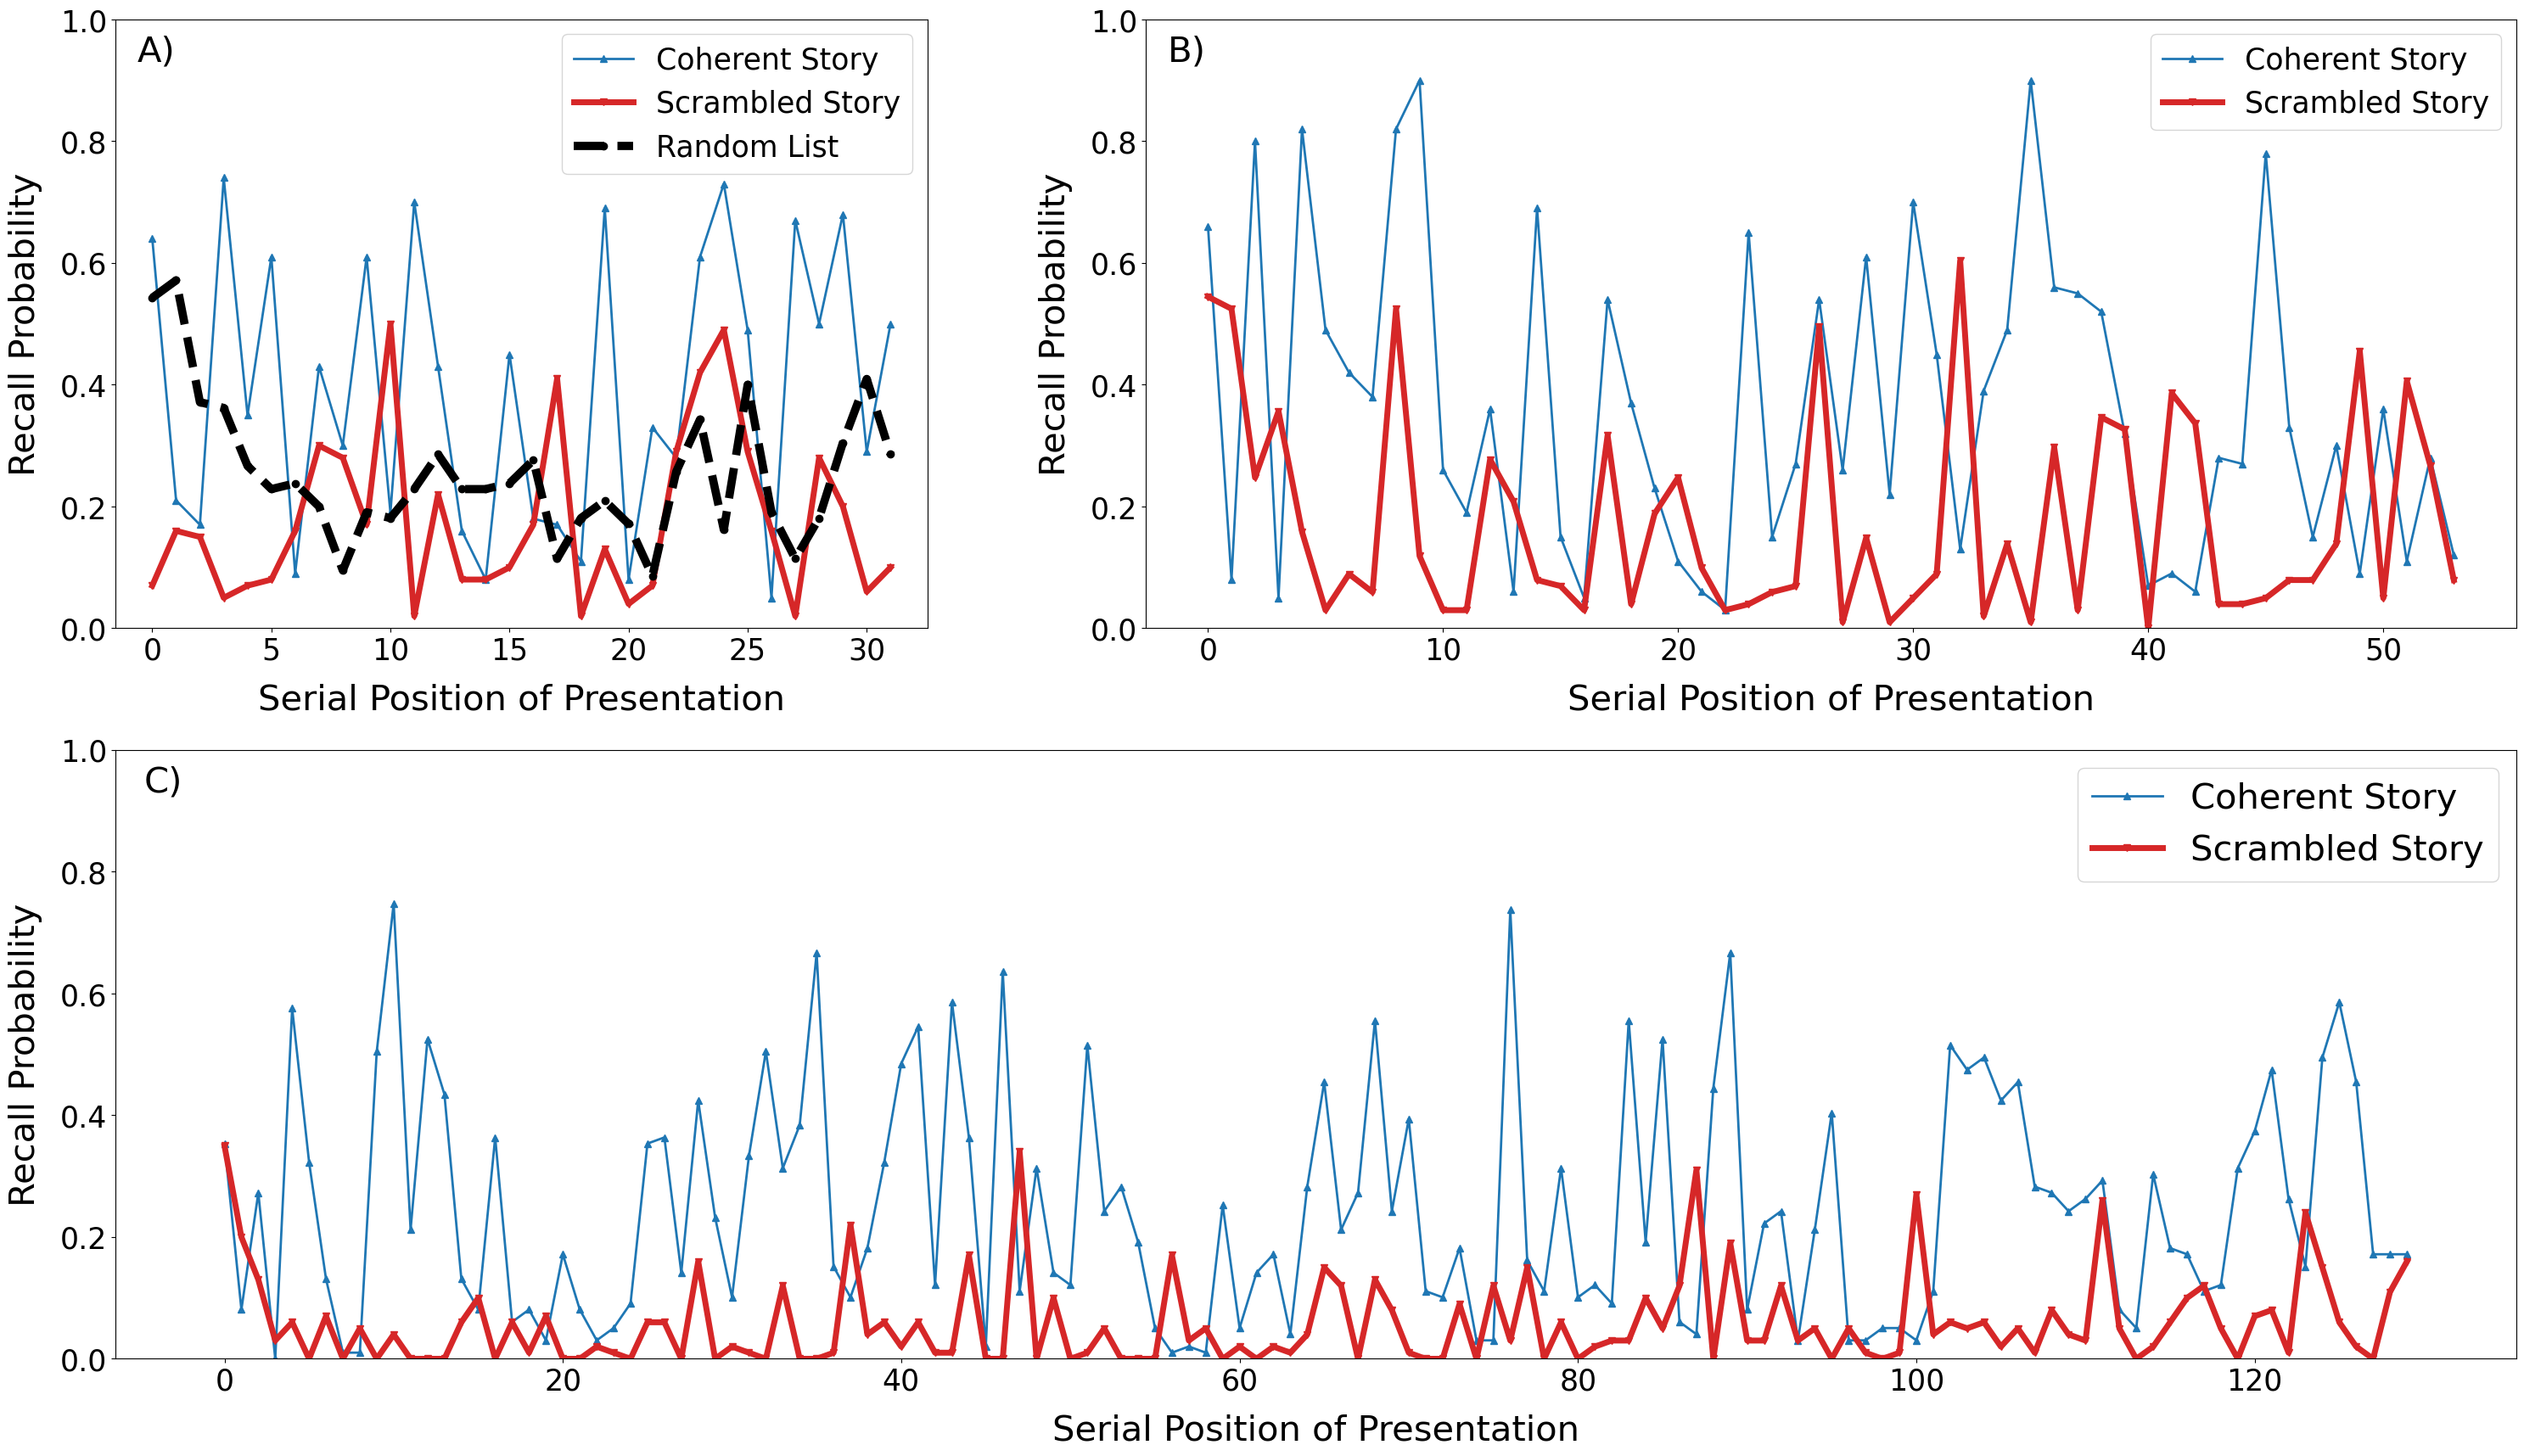

In [318]:

#gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
  

fig = plt.figure(figsize=(36.5, 20.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2,width_ratios=[32,54.])


ax0 = fig.add_subplot(spec[1, :])

ids = 0;
id_scram = 11
#plt.figure(figsize = (25,8))
ax0.plot(prec_list[2],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax0.plot(prec_list_scram[2][seg_map_list[2]],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
#plt.plot(Prec_list[id_scram],'-v',color = 'tab:green',label = 'Scrambled Story')
#plt.plot(word_data['serial_position_curve'],'--o',color = 'tab:orange',label = 'Random List')
ax0.set_ylim([0,1])
ax0.set_xlabel('Serial Position of Presentation',labelpad = 15,fontsize = 30)
ax0.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)

ax0.legend(fontsize = 30)


ax10 = fig.add_subplot(spec[0, 0])


id10 = 0
ax10.plot(prec_list[id10],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax10.plot(prec_list_scram[id10][seg_map_list[id10]],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
ax10.plot(word_data['serial_position_curve'],'--o',color = '0',linewidth = 7,label = 'Random List')
ax10.set_ylim([0,1])
ax10.set_xlabel('Serial Position of Presentation',labelpad = 15,fontsize = 30)
ax10.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)
#ax10.set_title('Serial Position Curves',fontsize = 20)
ax10.legend(fontsize = 25)


ax11 = fig.add_subplot(spec[0, 1])

id11 = 1
ax11.plot(prec_list[id11],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax11.plot(prec_list_scram[id11][seg_map_list[id11]],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
#plt.plot(word_data['serial_position_curve'],'--o',color = 'tab:orange',label = 'Random List')
ax11.set_ylim([0,1])
ax11.set_xlabel('Serial Position of Presentation',labelpad = 15,fontsize = 30)
ax11.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)
#ax11.set_title('Serial Position Curves',fontsize = 20)
ax11.legend(fontsize = 25)


ax0.tick_params(axis='both', which='major', labelsize=25)
ax10.tick_params(axis='both', which='major', labelsize=25)
ax11.tick_params(axis='both', which='major', labelsize=25)

#plt.title('Serial Position Curve')

ax10.set_title('A)',fontsize = 30,x = .05, y = 1,pad = -35)
ax11.set_title('B)',fontsize = 30,x = .03, y = 1,pad = -35)
ax0.set_title('C)', fontsize = 30,x = .02, y = 1,pad = -35)



plt.savefig('serial-position-curves.pdf',bbox_inches = 'tight')
plt.show()



## Cumulative Distribution of Recall Probabilities for Coherent and Scrambled Stories (Appendix D,  Figure 8)

In [332]:
x = np.array([i for i in range(1000)])/1000

def cum_dist(p,x):
    c_dist = []
    for i in range(len(x)):
        c_dist +=[np.sum(1.*(p>x[i]))/len(p)]
    
    return c_dist

In [324]:

scram_set = ['boyscout-scrambled.pkl','triplett_v1-rookie-scrambled.pkl','hester_v2-church-scrambled.pkl','stein-scrambled.pkl']

exclude_set = ['panic.pkl']
include_set = []

for f in files_in_folder('compiled_data','.pkl'):
    if f not in scram_set:
        if f not in exclude_set:
            include_set +=[f];
    

In [325]:
#order include_set by length of story

include_set_len = []
for i in range(len(include_set)):
    f = include_set[i]
    include_set_len +=[len(prec_dict[f])]
include_set = np.array(include_set)[np.argsort(include_set_len)]

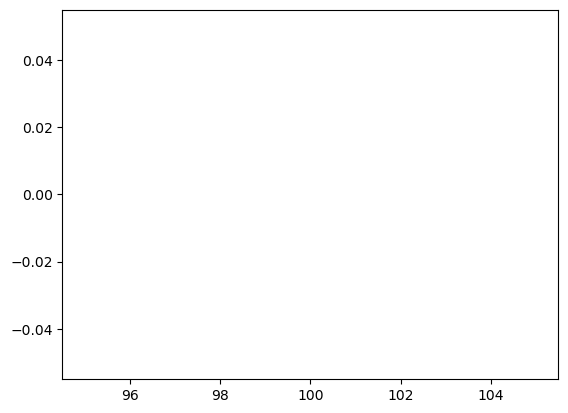

In [329]:
plt.plot(x,cum_dist(prec,x),'-',label = 'L = '+str(len(prec)))

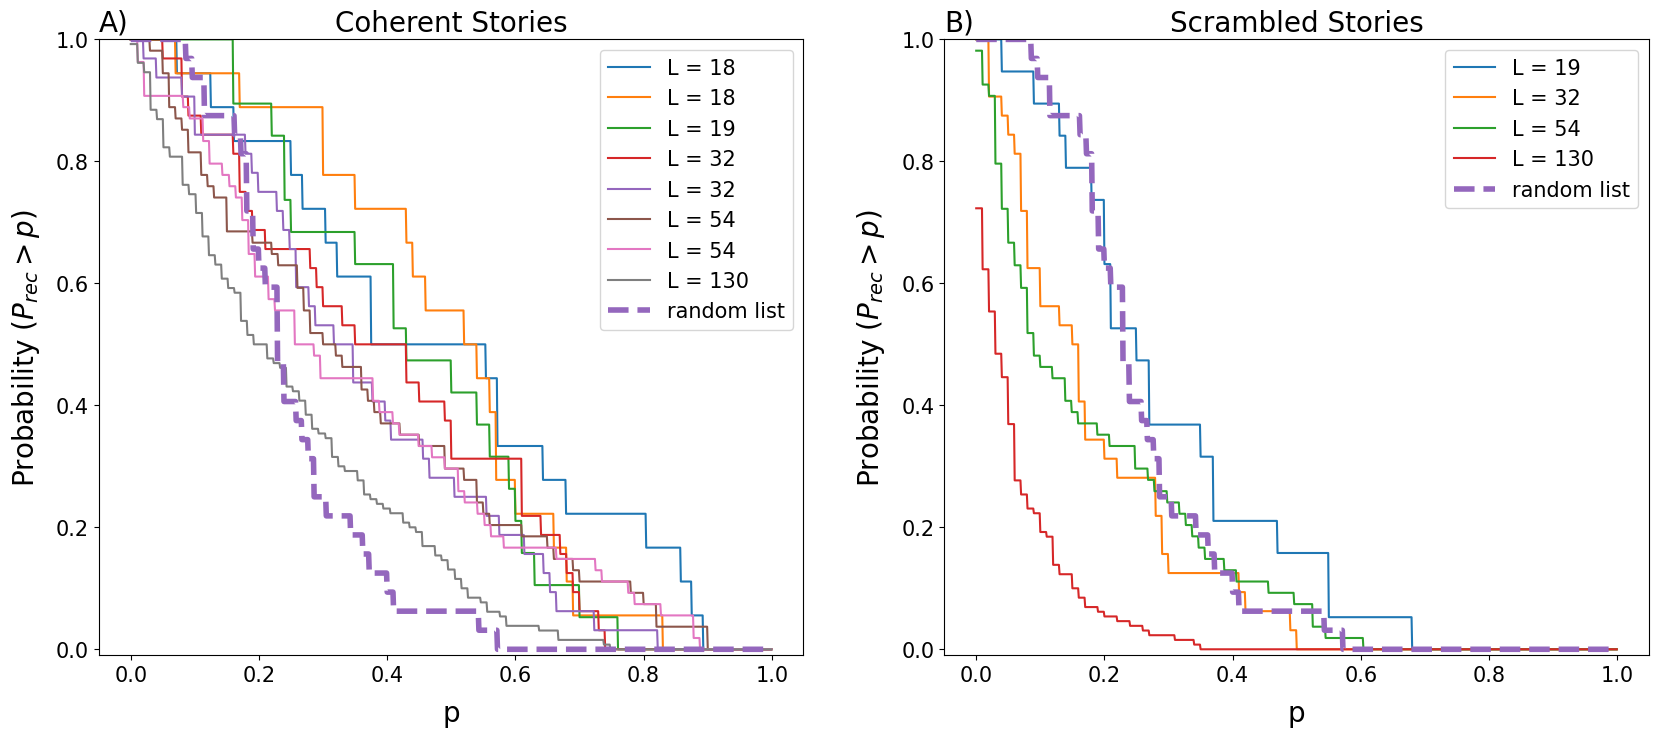

In [334]:
p1 = 0;
p2 = 1;
p3 = 0

num_plots = len(include_set) + 1
#fig, ax = plt.subplots(1,num_plots,figsize=(51,8))#
fig, ax = plt.subplots(1,2,figsize=(20,8))#

for f in include_set:
    prec = prec_dict[f]
    #ax[p1].plot(np.array(range(len(Prec_list[ids]))),np.sort(Prec_list[ids])[::-1],'-',label = 'L = '+str(len(Prec_list[ids])))
 
    ax[p1].plot(x,cum_dist(prec,x),'-',label = 'L = '+str(len(prec)))
    #plt.plot(np.sort(Prec_list[ids])[::-1],'-o',label = story_name[ids])
    #ax[i].plot(word_data['serial_position_curve'],'--',color = 'red')

#colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
#colors = [colormap(len(Prec_list[arg_include[i]])) for i in np.linspace(0, .6,len(ax[p1].lines))]
#for i,j in enumerate(ax[p1].lines):
#    j.set_color(colors[i])
  



    
for f in scram_set:
    prec= prec_dict[f]
    ax[p2].plot(x,cum_dist(prec,x),'-',label = 'L = '+str(len(prec)))
    #plt.plot(np.sort(Prec_list[ids])[::-1],'-o',label = story_name[ids])
    #ax[i].plot(word_data['serial_position_curve'],'--',color = 'red')

#ax[p1].plot(np.array(range(len(word_data['serial_position_curve']))),np.sort(word_data['serial_position_curve'])[::-1],'--',color = 'tab:purple',linewidth = 4,label= 'random list')
ax[p1].plot(x,cum_dist(word_data['serial_position_curve'],x),'--',color = 'tab:purple',linewidth = 4,label= 'random list')

ax[p2].plot(x,cum_dist(word_data['serial_position_curve'],x),'--',color = 'tab:purple',linewidth = 4,label= 'random list')


#ax[p2].plot(np.array(range(len(word_data['serial_position_curve'])))/len(word_data['serial_position_curve']),np.sort(word_data['serial_position_curve'])[::-1],'--',color = 'tab:purple',linewidth = 4,label= 'random list')

ax[p1].set_xlabel('p',labelpad = 10,fontsize = 20)
ax[p2].set_xlabel('p',labelpad = 10,fontsize = 20)

ax[p1].set_ylabel('Probability $(P_{rec} > p)$',labelpad = 10,fontsize = 20)
ax[p2].set_ylabel('Probability $(P_{rec} > p)$',labelpad = 10,fontsize = 20)

ax[p1].set_title('Coherent Stories',fontsize = 20)
ax[p2].set_title('Scrambled Stories',fontsize = 20)

#ax[p1].legend(loc=2)
ax[p1].legend(fontsize = 15)
ax[p2].legend(fontsize = 15)


ax[p1].set_ylim([-.01,1])
ax[p2].set_ylim([-0.01,1])


ax[p1].tick_params(axis='both', which='major', labelsize=15)
ax[p2].tick_params(axis='both', which='major', labelsize=15)

ax[p1].set_title('A)',  loc='left', fontsize=20)
ax[p2].set_title('B)',  loc='left', fontsize=20)


plt.savefig('figs/cumulative-probability-prec.pdf',bbox_inches='tight')

plt.show()

## Descrambled Serial Position Curves + Scatter Plot (Appendix D, Figure 9)

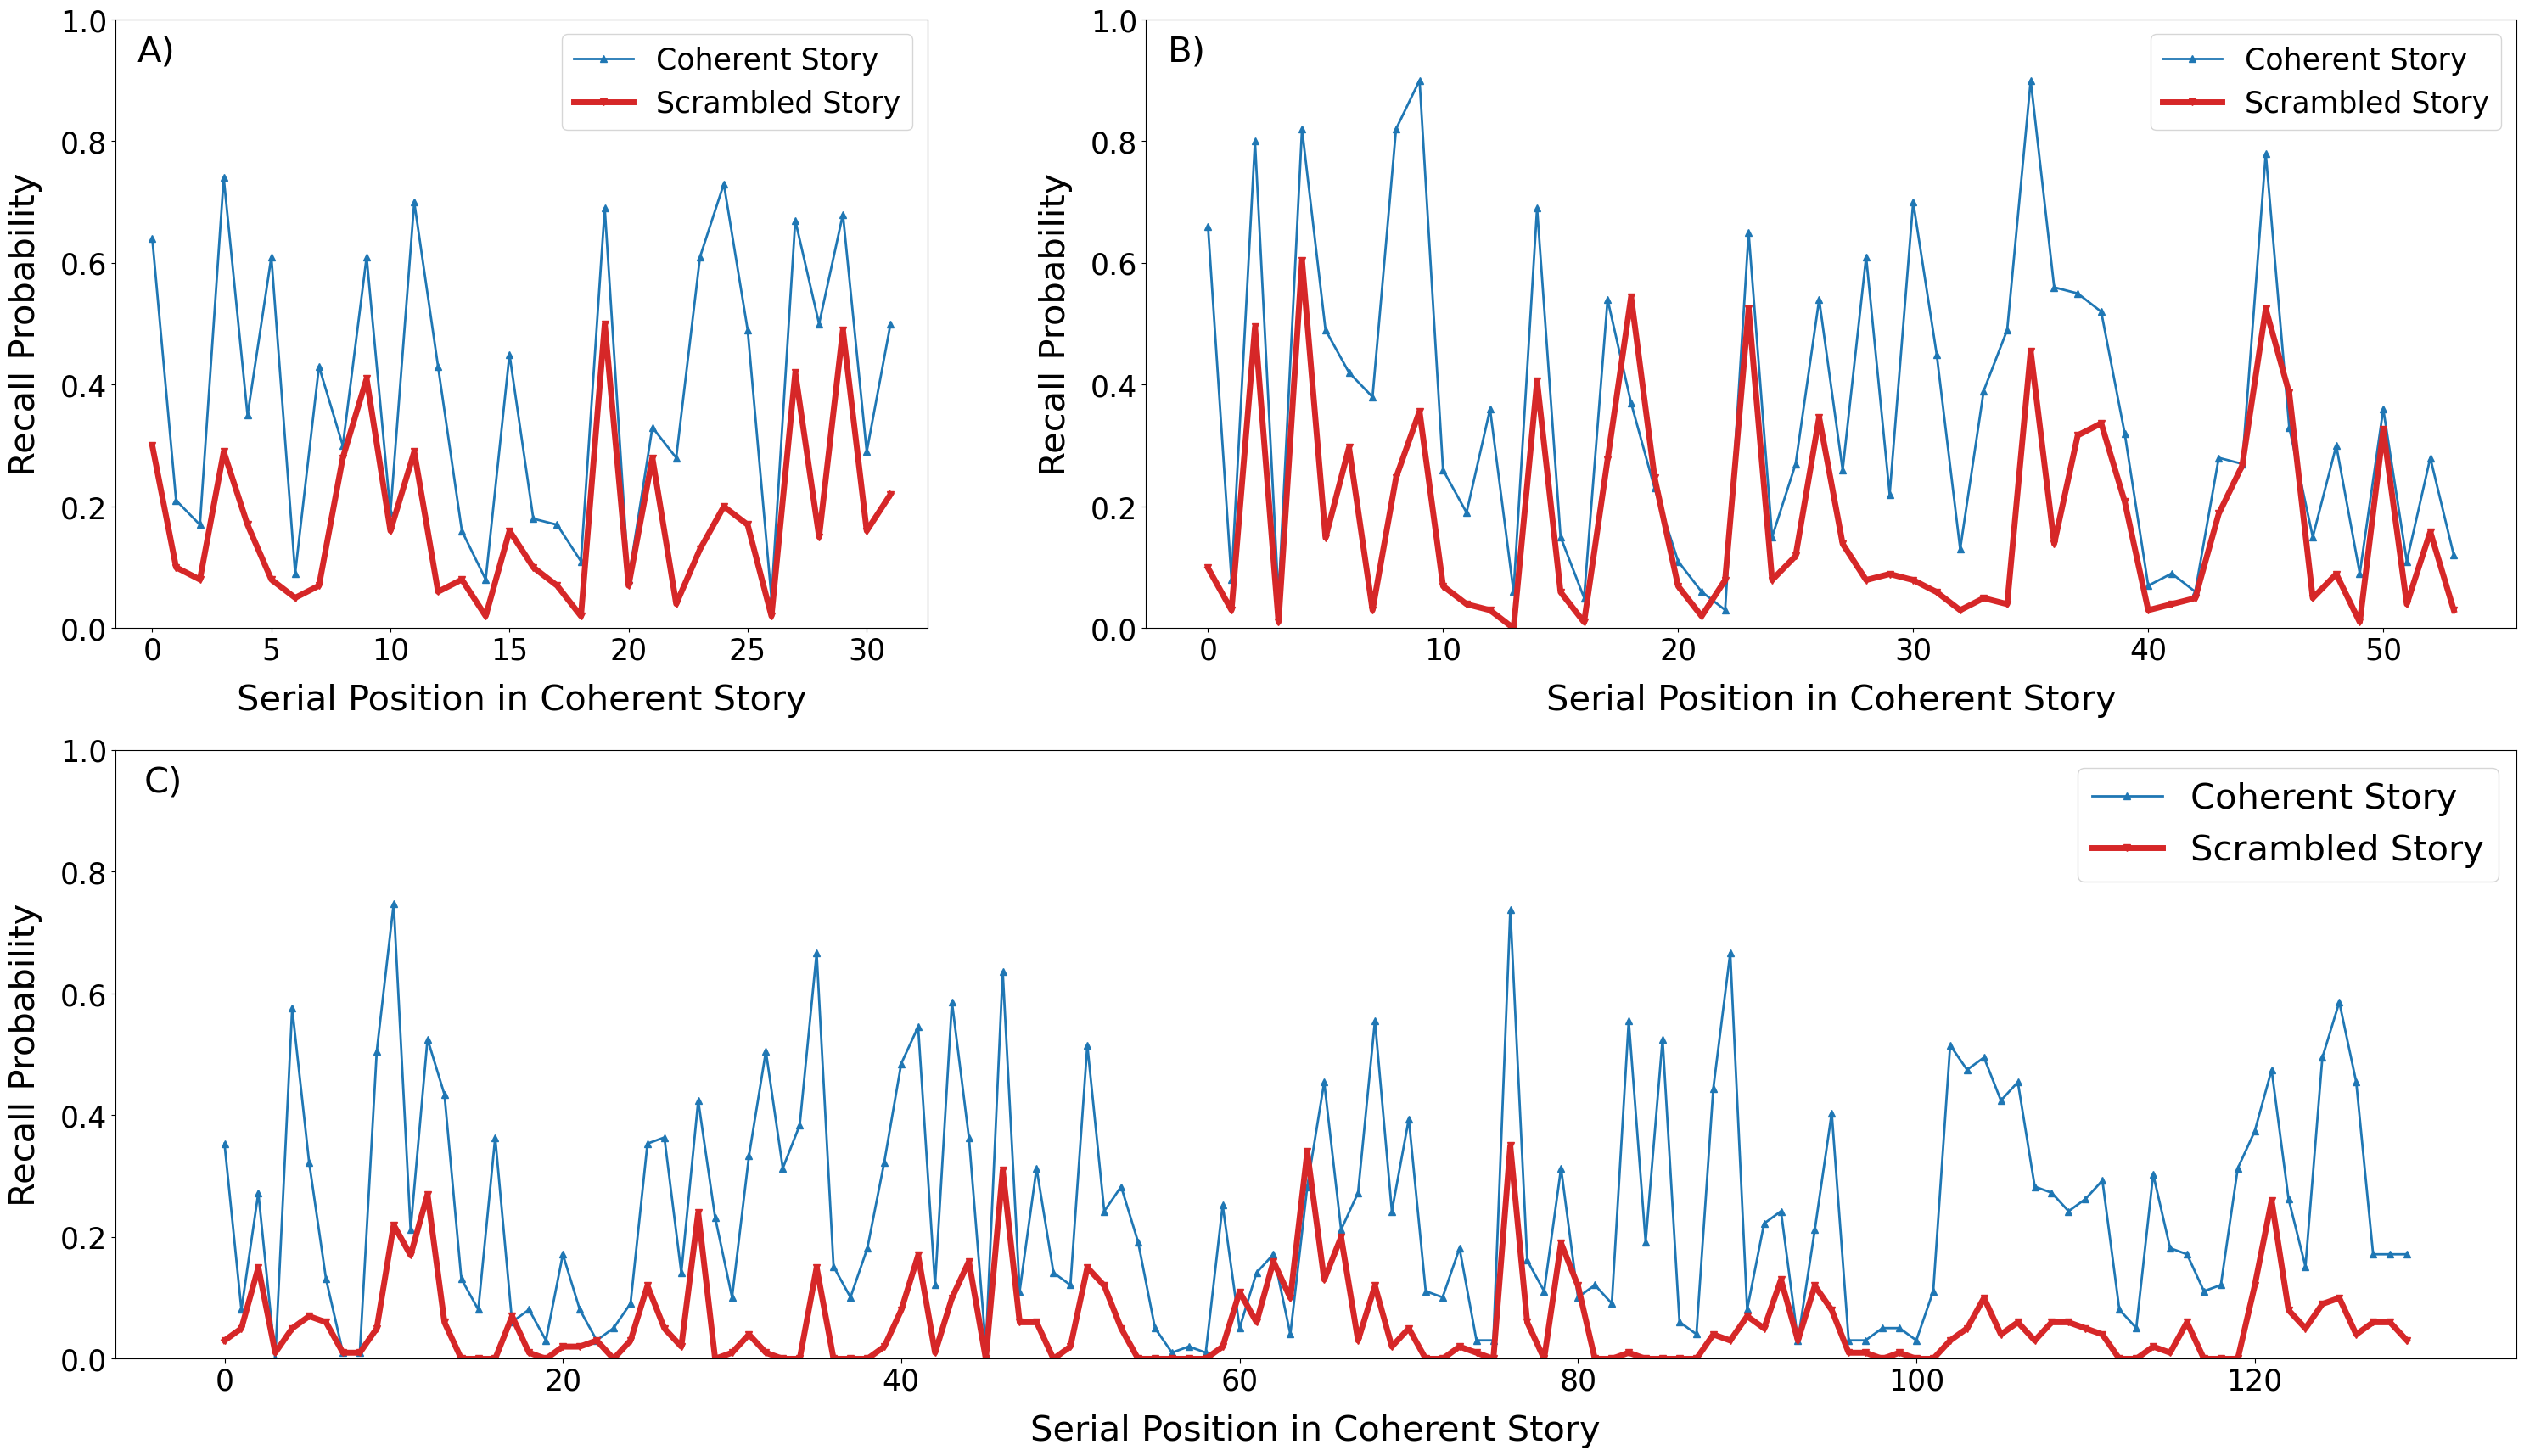

In [335]:


fig = plt.figure(figsize=(36.5, 20.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2,width_ratios=[32,54.])


ax0 = fig.add_subplot(spec[1, :])

id0 = 2
#plt.figure(figsize = (25,8))
ax0.plot(prec_list[id0],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax0.plot(prec_list_scram[id0],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
#plt.plot(Prec_list[id_scram],'-v',color = 'tab:green',label = 'Scrambled Story')
#plt.plot(word_data['serial_position_curve'],'--o',color = 'tab:orange',label = 'Random List')
ax0.set_ylim([0,1])
ax0.set_xlabel('Serial Position in Coherent Story',labelpad = 15,fontsize = 30)
ax0.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)

ax0.legend(fontsize = 30)


ax10 = fig.add_subplot(spec[0, 0])


id10 = 0
ax10.plot(prec_list[id10],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax10.plot(prec_list_scram[id10],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
ax10.set_ylim([0,1])
ax10.set_xlabel('Serial Position in Coherent Story',labelpad = 15,fontsize = 30)
ax10.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)
#ax10.set_title('Serial Position Curves',fontsize = 20)
ax10.legend(fontsize = 25)


ax11 = fig.add_subplot(spec[0, 1])

id11 = 1
ax11.plot(prec_list[id11],'-^',color = 'tab:blue',linewidth = 2,label = 'Coherent Story')
ax11.plot(prec_list_scram[id11],'-v',linewidth = 5,color = 'tab:red',label = 'Scrambled Story')
#plt.plot(word_data['serial_position_curve'],'--o',color = 'tab:orange',label = 'Random List')
ax11.set_ylim([0,1])
ax11.set_xlabel('Serial Position in Coherent Story',labelpad = 15,fontsize = 30)
ax11.set_ylabel('Recall Probability',labelpad = 15,fontsize = 30)
#ax11.set_title('Serial Position Curves',fontsize = 20)
ax11.legend(fontsize = 25)


ax0.tick_params(axis='both', which='major', labelsize=25)
ax10.tick_params(axis='both', which='major', labelsize=25)
ax11.tick_params(axis='both', which='major', labelsize=25)

#plt.title('Serial Position Curve')

ax10.set_title('A)',fontsize = 30,x = .05, y = 1,pad = -35)
ax11.set_title('B)',fontsize = 30,x = .03, y = 1,pad = -35)
ax0.set_title('C)', fontsize = 30,x = .02, y = 1,pad = -35)



plt.savefig('figs/descrambled-serial-position-curves.pdf',bbox_inches = 'tight')
plt.show()



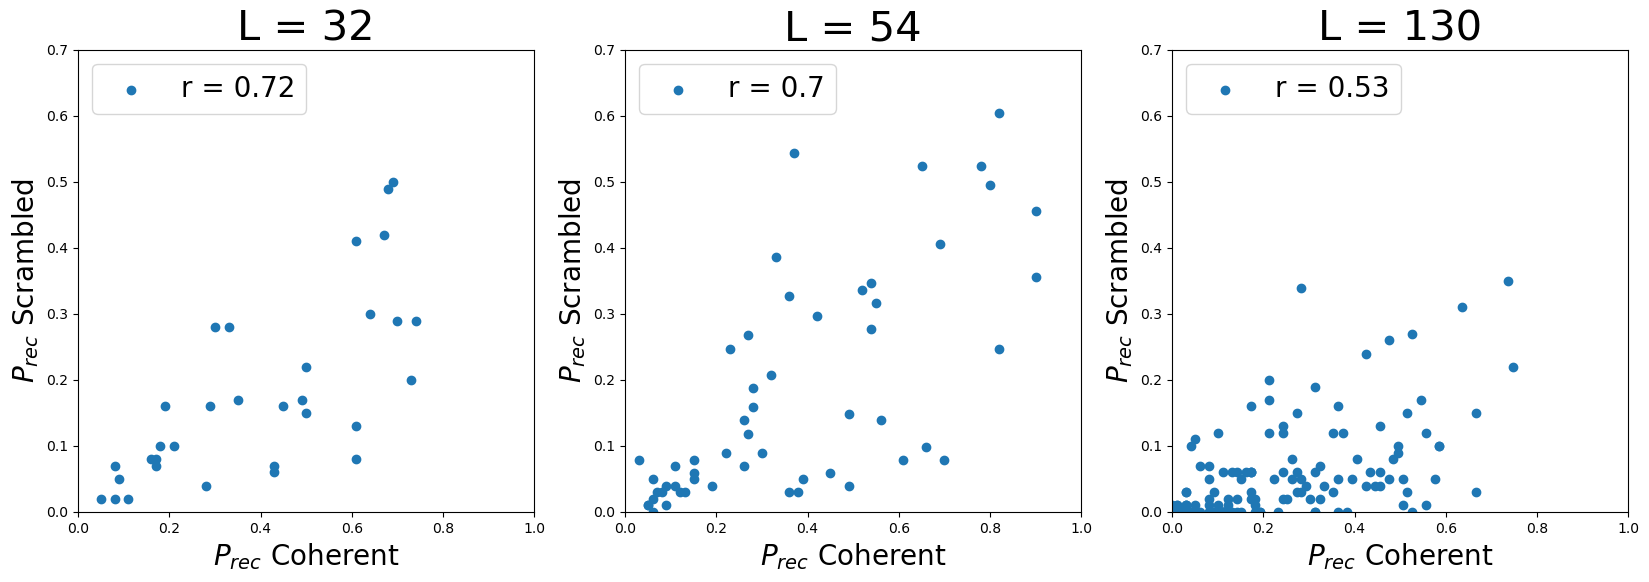

In [336]:
#compute r-values for descrambled recall probabilities

reg = []
for i in range(3):
    reg+=[linregress(prec_list[i],prec_list_scram[i])]



fig, ax = plt.subplots(1,3,figsize=(20,6))#

ids = 13;
id_scram = 11

rval = []
for i in range(len(reg)):
    rval+= [np.round(reg[i].rvalue,2)]

for i in range(3):
    ax[i].scatter(prec_list[i],prec_list_scram[i],label = 'r = '+str(rval[i]))
#ax[1].scatter(prec_list[2],Prec_list[8],label = 'r = '+str(rval[i]))
#ax[2].scatter(prec_list[13],Prec_list[11],label = 'r = '+str(rval[i]))
    ax[i].set_title('L = '+str(len(prec_list[i])),fontsize = 30)
for i in range(3):
    ax[i].set_ylim([0,.7])
    ax[i].set_xlim([0,1])
    ax[i].set_ylabel('$P_{rec}$ Scrambled',fontsize = 20)
    ax[i].set_xlabel('$P_{rec}$ Coherent',fontsize = 20)
    ax[i].legend(fontsize = 20,loc = 'upper left')




plt.savefig('figs/correlation_prec.pdf',bbox_inches = 'tight')

plt.show()